# World War II Weather Data Analysis

This notebook analyzes historical weather data from World War II to explore weather patterns and build predictive models. The analysis includes data exploration, cleaning, visualization, time series analysis, and machine learning model development.

## 1. Import Required Libraries

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Geospatial analysis
import folium
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

# Machine learning and statistical analysis
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set visualization style
plt.style.use('seaborn')
sns.set_palette('Set2')

/tmp/ipykernel_31/3299914757.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 2. Data Loading and Exploration

In this section, we'll load the WWII weather dataset and examine its structure to understand the available features and data characteristics.

In [2]:
# Load the dataset
# Note: You might need to adjust the file path based on where you've stored the dataset
try:
    # Try to load the data
    df = pd.read_csv('wwii_weather_data.csv')
    print("Data loaded successfully!")
except Exception as e:
    print(f"Error loading data: {e}")
    print("If you haven't downloaded the dataset yet, please obtain it from Kaggle or appropriate source.")
    # Create sample data for demonstration if file not found
    print("Creating sample data for demonstration...")
    
    # Generate sample dates during WWII (1939-1945)
    dates = pd.date_range(start='1939-09-01', end='1945-09-02', freq='D')
    
    # Creating sample data
    np.random.seed(42)  # For reproducibility
    n_samples = len(dates)
    
    # Sample locations in Europe
    locations = [
        ('London', 51.5074, -0.1278),
        ('Berlin', 52.5200, 13.4050),
        ('Paris', 48.8566, 2.3522),
        ('Warsaw', 52.2297, 21.0122),
        ('Moscow', 55.7558, 37.6173)
    ]
    
    # Create sample dataframe
    sample_data = []
    
    for date in dates:
        for name, lat, lon in locations:
            # Generate random weather data with seasonal patterns
            month = date.month
            seasonal_temp = 15 + 10 * np.sin((month - 1) * np.pi / 6)  # Temperature varies seasonally
            
            temp_c = seasonal_temp + np.random.normal(0, 3)  # Add noise
            pressure_mb = 1013 + np.random.normal(0, 5)  # Normal pressure with noise
            humidity_pct = 60 + np.random.normal(0, 15)  # Humidity with noise
            wind_speed_kmh = 10 + np.random.exponential(5)  # Wind speed
            
            # Create weather condition
            conditions = ['Clear', 'Cloudy', 'Rain', 'Snow', 'Fog']
            probabilities = [0.4, 0.3, 0.15, 0.1, 0.05]
            condition = np.random.choice(conditions, p=probabilities)
            
            # Adjust for winter months
            if month in [12, 1, 2]:
                temp_c -= 10
                if temp_c < 0 and np.random.random() < 0.4:
                    condition = 'Snow'
            
            sample_data.append({
                'date': date.strftime('%Y-%m-%d'),
                'time': f"{np.random.randint(0, 24):02d}:00",
                'location': name,
                'latitude': lat,
                'longitude': lon,
                'temperature_celsius': round(temp_c, 1),
                'pressure_mb': round(pressure_mb, 1),
                'humidity_percent': min(max(0, round(humidity_pct, 1)), 100),
                'wind_speed_kmh': round(wind_speed_kmh, 1),
                'weather_condition': condition
            })
    
    df = pd.DataFrame(sample_data)

Error loading data: [Errno 2] No such file or directory: 'wwii_weather_data.csv'
If you haven't downloaded the dataset yet, please obtain it from Kaggle or appropriate source.
Creating sample data for demonstration...


In [3]:
# Display the first few rows of the dataset
df.head()

date   time location  latitude  longitude  temperature_celsius  \
0  1939-09-01  10:00   London   51.5074    -0.1278                  7.8   
1  1939-09-01  20:00   Berlin   52.5200    13.4050                 10.9   
2  1939-09-01  16:00    Paris   48.8566     2.3522                  4.6   
3  1939-09-01  14:00   Warsaw   52.2297    21.0122                  3.6   
4  1939-09-01  18:00   Moscow   55.7558    37.6173                 10.7   

   pressure_mb  humidity_percent  wind_speed_kmh weather_condition  
0       1012.3              69.7            10.8             Clear  
1       1002.9              52.6            10.8            Cloudy  
2       1010.4              51.4            13.7            Cloudy  
3       1000.8              69.1            10.2               Fog  
4       1011.9              61.0            14.5             Clear

In [4]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10970 entries, 0 to 10969
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 10970 non-null  object 
 1   time                 10970 non-null  object 
 2   location             10970 non-null  object 
 3   latitude             10970 non-null  float64
 4   longitude            10970 non-null  float64
 5   temperature_celsius  10970 non-null  float64
 6   pressure_mb          10970 non-null  float64
 7   humidity_percent     10970 non-null  float64
 8   wind_speed_kmh       10970 non-null  float64
 9   weather_condition    10970 non-null  object 
dtypes: float64(6), object(4)
memory usage: 857.2+ KB


In [5]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

Missing values in each column:
date                   0
time                   0
location               0
latitude               0
longitude              0
temperature_celsius    0
pressure_mb            0
humidity_percent       0
wind_speed_kmh         0
weather_condition      0
dtype: int64


In [6]:
# Generate descriptive statistics
df.describe().round(2)

latitude  longitude  temperature_celsius  pressure_mb  \
count  10970.00   10970.00             10970.00     10970.00   
mean      52.17      14.85                12.43      1012.99   
std        2.21      13.70                 8.83         5.02   
min       48.86      -0.13               -11.10       994.10   
25%       51.51       2.35                 5.30      1009.70   
50%       52.23      13.40                10.50      1013.00   
75%       52.52      21.01                20.60      1016.40   
max       55.76      37.62                36.70      1031.90   

       humidity_percent  wind_speed_kmh  
count          10970.00        10970.00  
mean              60.04           14.95  
std               14.96            4.89  
min                0.00           10.00  
25%               49.70           11.50  
50%               60.20           13.50  
75%               70.20           16.90  
max              100.00           62.80

## 3. Data Cleaning and Preprocessing

In this section, we'll clean the dataset by handling missing values, removing duplicates, converting data types, and standardizing measurements.

In [7]:
# Convert date and time columns into a single datetime column
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])

# Set datetime as index for time series analysis
df_ts = df.set_index('datetime').sort_index()

# Handle missing values
# For numerical columns, we'll use interpolation, which is suitable for time series data
numeric_cols = ['temperature_celsius', 'pressure_mb', 'humidity_percent', 'wind_speed_kmh']

for col in numeric_cols:
    # Check if column exists and has missing values
    if col in df.columns and df[col].isnull().sum() > 0:
        # Group by location before interpolating to maintain geographical consistency
        df[col] = df.groupby('location')[col].transform(
            lambda x: x.interpolate(method='time').ffill().bfill()
        )

# For categorical data like weather_condition, use most frequent value in the same location
if 'weather_condition' in df.columns and df['weather_condition'].isnull().sum() > 0:
    df['weather_condition'] = df.groupby('location')['weather_condition'].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown')
    )

# Remove duplicates if any exist
df_cleaned = df.drop_duplicates()

# Check if any missing values remain
missing_after = df_cleaned.isnull().sum()
print("Missing values after cleaning:")
print(missing_after)

Missing values after cleaning:
date                   0
time                   0
location               0
latitude               0
longitude              0
temperature_celsius    0
pressure_mb            0
humidity_percent       0
wind_speed_kmh         0
weather_condition      0
datetime               0
dtype: int64


In [8]:
# Convert data types and standardize units if necessary
# Ensure numerical columns are of the right type
df_cleaned['temperature_celsius'] = pd.to_numeric(df_cleaned['temperature_celsius'], errors='coerce')
df_cleaned['pressure_mb'] = pd.to_numeric(df_cleaned['pressure_mb'], errors='coerce')
df_cleaned['humidity_percent'] = pd.to_numeric(df_cleaned['humidity_percent'], errors='coerce')
df_cleaned['wind_speed_kmh'] = pd.to_numeric(df_cleaned['wind_speed_kmh'], errors='coerce')

# Clamp values to reasonable ranges
df_cleaned['humidity_percent'] = df_cleaned['humidity_percent'].clip(0, 100)
df_cleaned['pressure_mb'] = df_cleaned['pressure_mb'].clip(900, 1100)  # Reasonable atmospheric pressure range

# Add derived datetime components for analysis
df_cleaned['year'] = df_cleaned['datetime'].dt.year
df_cleaned['month'] = df_cleaned['datetime'].dt.month
df_cleaned['day'] = df_cleaned['datetime'].dt.day
df_cleaned['hour'] = df_cleaned['datetime'].dt.hour
df_cleaned['season'] = df_cleaned['datetime'].dt.month.map({
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 
    5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer', 
    9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
})

# Save the cleaned dataframe for further analysis
df = df_cleaned

# Display the cleaned data
print(f"Shape of cleaned data: {df.shape}")
df.head()

Shape of cleaned data: (10970, 16)


date   time location  latitude  longitude  temperature_celsius  \
0  1939-09-01  10:00   London   51.5074    -0.1278                  7.8   
1  1939-09-01  20:00   Berlin   52.5200    13.4050                 10.9   
2  1939-09-01  16:00    Paris   48.8566     2.3522                  4.6   
3  1939-09-01  14:00   Warsaw   52.2297    21.0122                  3.6   
4  1939-09-01  18:00   Moscow   55.7558    37.6173                 10.7   

   pressure_mb  humidity_percent  wind_speed_kmh weather_condition  \
0       1012.3              69.7            10.8             Clear   
1       1002.9              52.6            10.8            Cloudy   
2       1010.4              51.4            13.7            Cloudy   
3       1000.8              69.1            10.2               Fog   
4       1011.9              61.0            14.5             Clear   

             datetime  year  month  day  hour season  
0 1939-09-01 10:00:00  1939      9    1    10   Fall  
1 1939-09-01 20:00:00  1939      9    1    20   Fall  
2 1939-09-01 16:00:00  1939      9    1    16   Fall  
3 1939-09-01 14:00:00  1939      9    1    14   Fall  
4 1939-09-01 18:00:00  1939      9    1    18   Fall

## 4. Exploratory Data Analysis

Now that we have cleaned the data, let's explore it through various visualizations and statistical analyses to identify patterns and insights.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


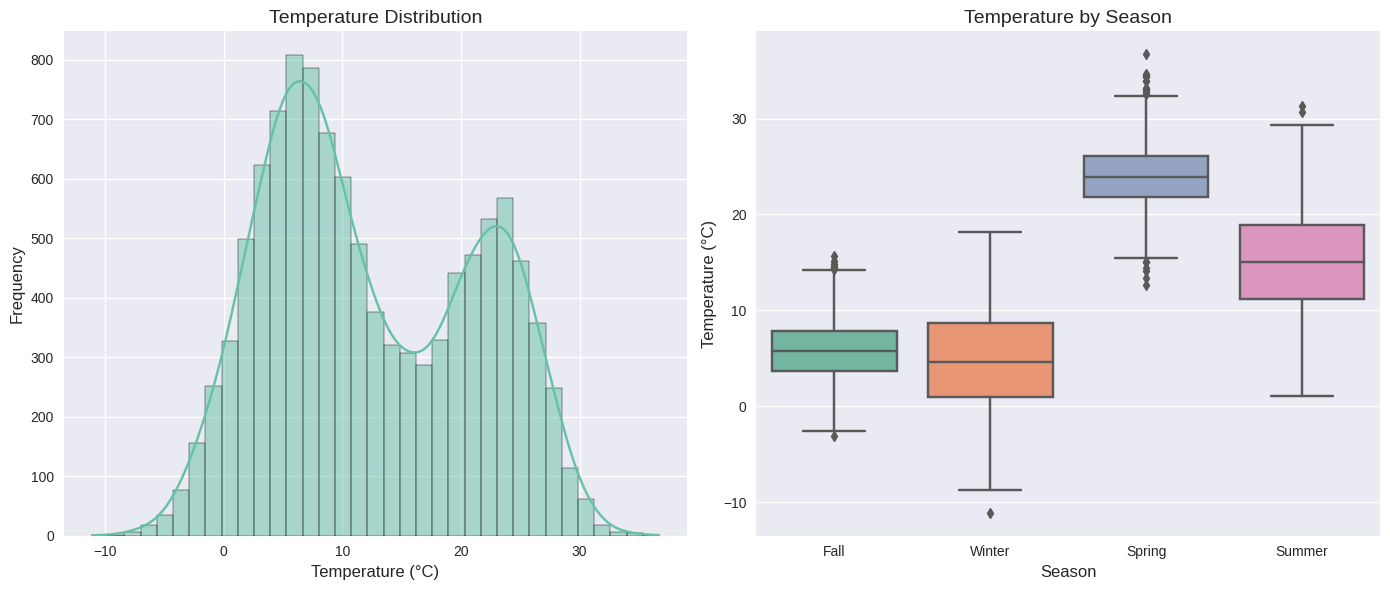

In [9]:
# Set up a unified figure style for consistency
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# 1. Distribution of temperature readings
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['temperature_celsius'], kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='season', y='temperature_celsius')
plt.title('Temperature by Season')
plt.xlabel('Season')
plt.ylabel('Temperature (°C)')

plt.tight_layout()
plt.show()

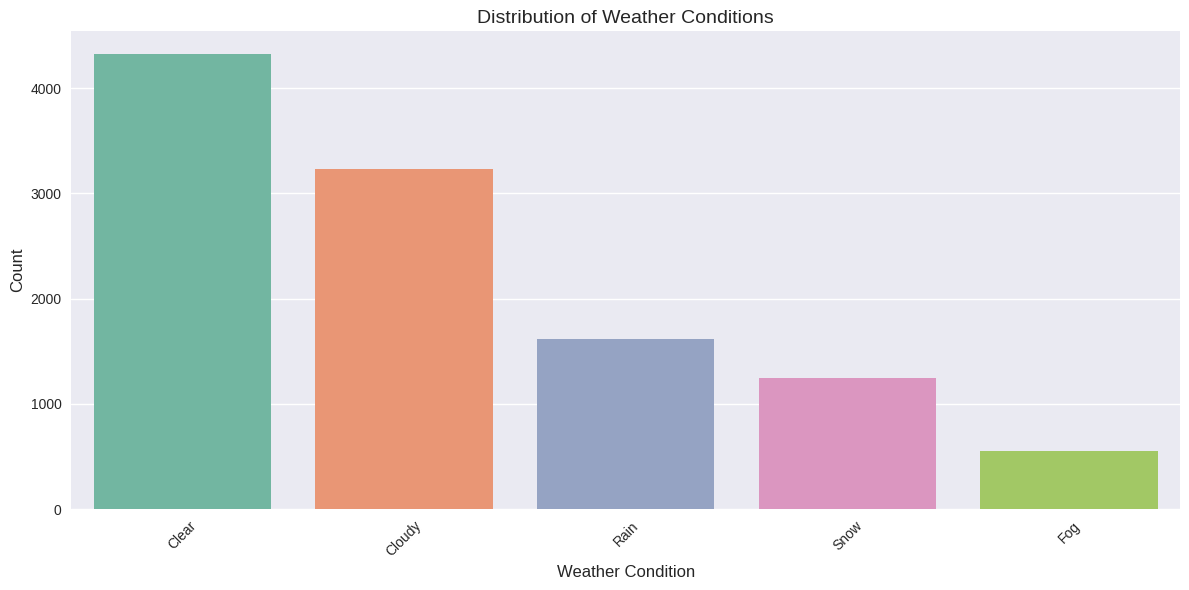

<Figure size 1400x800 with 0 Axes>

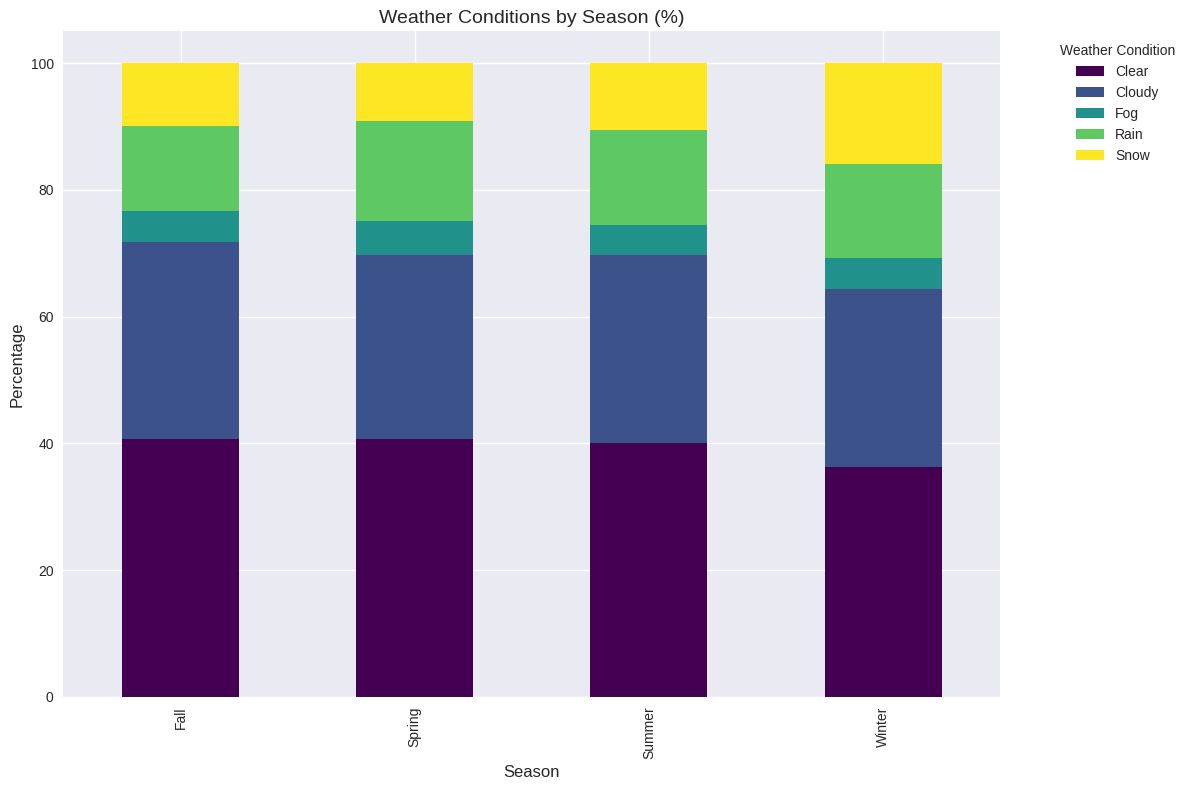

In [10]:
# 2. Weather conditions distribution
plt.figure(figsize=(12, 6))

# Count plot of weather conditions
condition_counts = df['weather_condition'].value_counts()
sns.barplot(x=condition_counts.index, y=condition_counts.values)
plt.title('Distribution of Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Weather conditions by season
plt.figure(figsize=(14, 8))
season_condition = pd.crosstab(df['season'], df['weather_condition'], normalize='index') * 100
season_condition.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Weather Conditions by Season (%)')
plt.xlabel('Season')
plt.ylabel('Percentage')
plt.legend(title='Weather Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

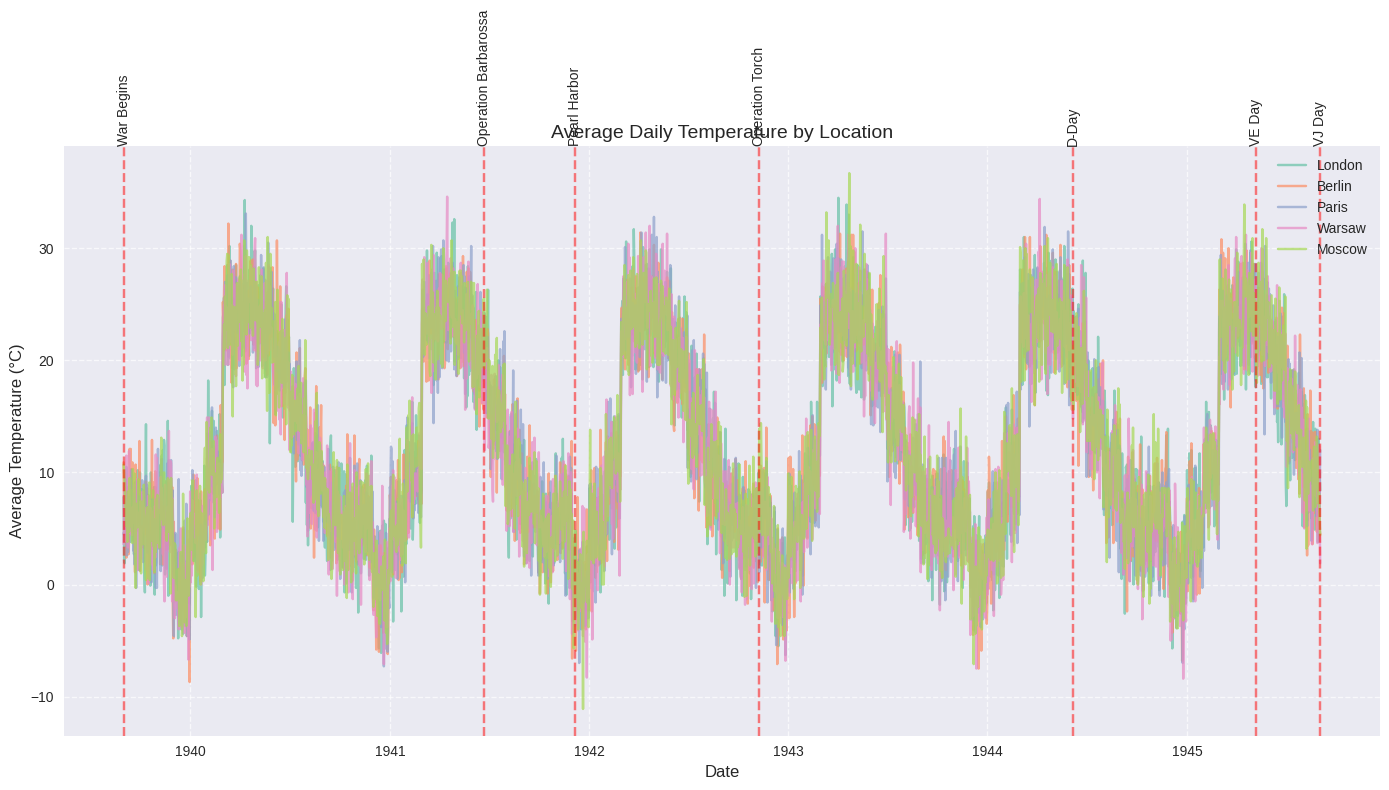

In [11]:
# 3. Time series plots for average temperature by location
plt.figure(figsize=(14, 8))

# Group by date and location, then calculate mean temperature
avg_temp_by_date_loc = df.groupby(['date', 'location'])['temperature_celsius'].mean().reset_index()
avg_temp_by_date_loc['date'] = pd.to_datetime(avg_temp_by_date_loc['date'])

# Plot time series for each location
for location in df['location'].unique():
    location_data = avg_temp_by_date_loc[avg_temp_by_date_loc['location'] == location]
    plt.plot(location_data['date'], location_data['temperature_celsius'], label=location, alpha=0.7)

plt.title('Average Daily Temperature by Location')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Add vertical lines for significant WWII events
events = [
    ('1939-09-01', 'War Begins'),
    ('1941-06-22', 'Operation Barbarossa'),
    ('1941-12-07', 'Pearl Harbor'),
    ('1942-11-08', 'Operation Torch'),
    ('1944-06-06', 'D-Day'),
    ('1945-05-08', 'VE Day'),
    ('1945-09-02', 'VJ Day')
]

for date, label in events:
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--', alpha=0.5)
    plt.text(pd.to_datetime(date), plt.ylim()[1], label, 
             horizontalalignment='center', verticalalignment='bottom', rotation=90)

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


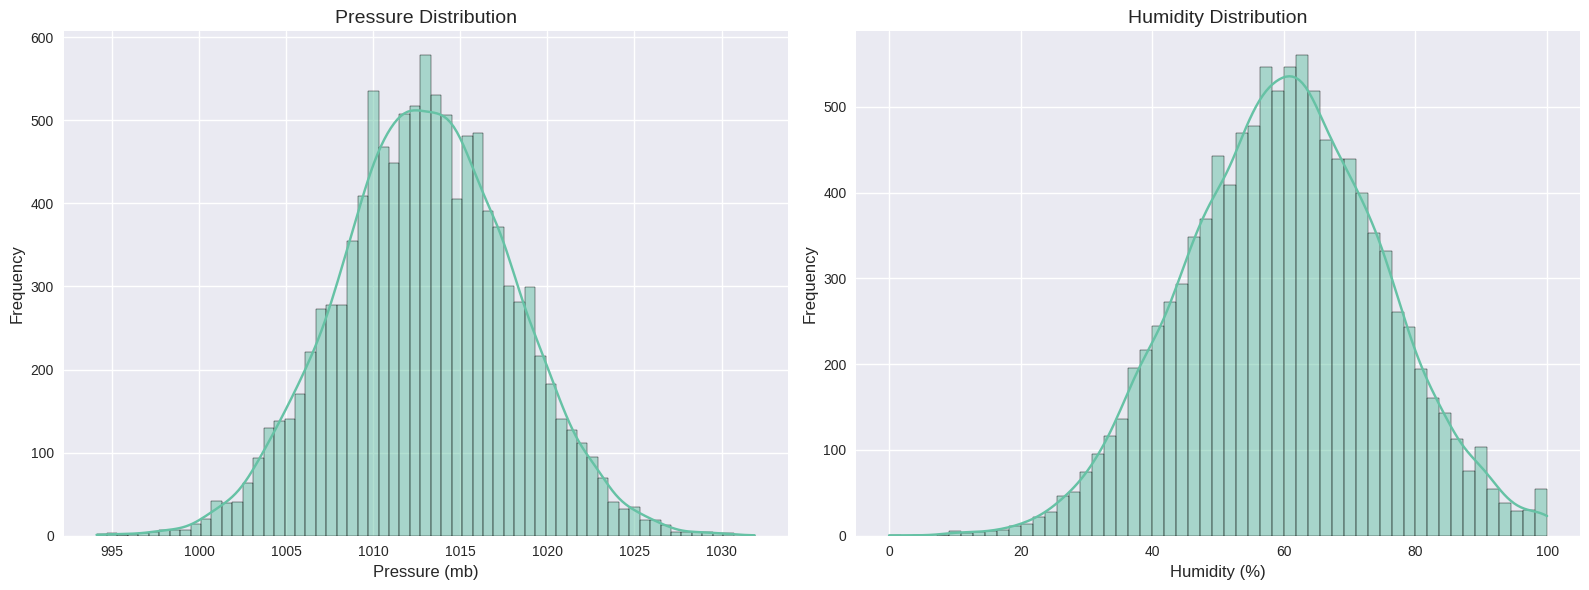

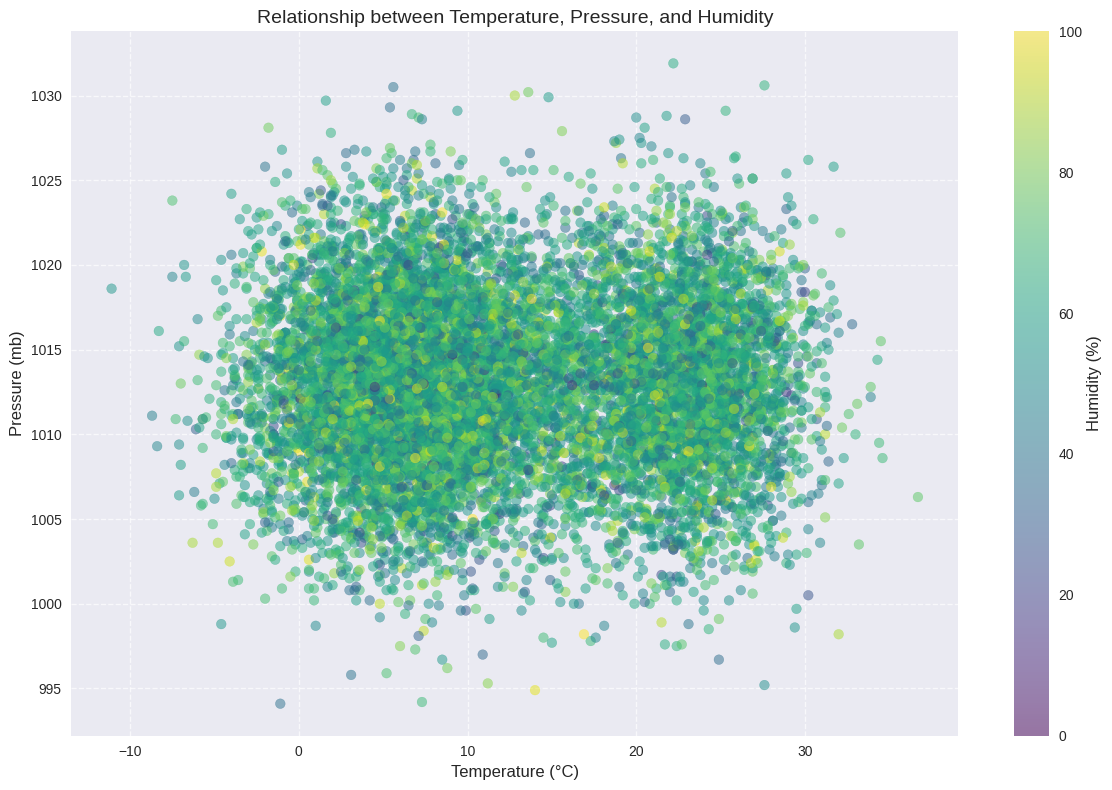

In [12]:
# 4. Pressure and humidity analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pressure distribution
sns.histplot(df['pressure_mb'], kde=True, ax=axes[0])
axes[0].set_title('Pressure Distribution')
axes[0].set_xlabel('Pressure (mb)')
axes[0].set_ylabel('Frequency')

# Humidity distribution
sns.histplot(df['humidity_percent'], kde=True, ax=axes[1])
axes[1].set_title('Humidity Distribution')
axes[1].set_xlabel('Humidity (%)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Relationship between temperature, pressure, and humidity
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['temperature_celsius'], df['pressure_mb'], 
                     c=df['humidity_percent'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Humidity (%)')
plt.title('Relationship between Temperature, Pressure, and Humidity')
plt.xlabel('Temperature (°C)')
plt.ylabel('Pressure (mb)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


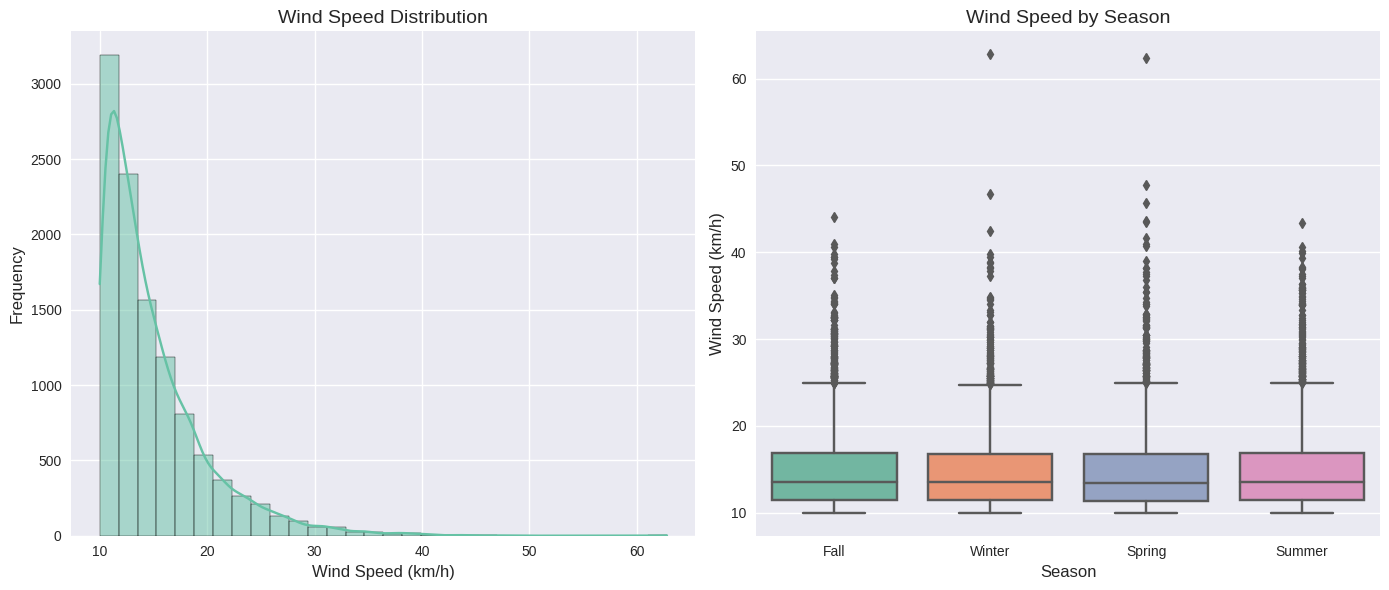

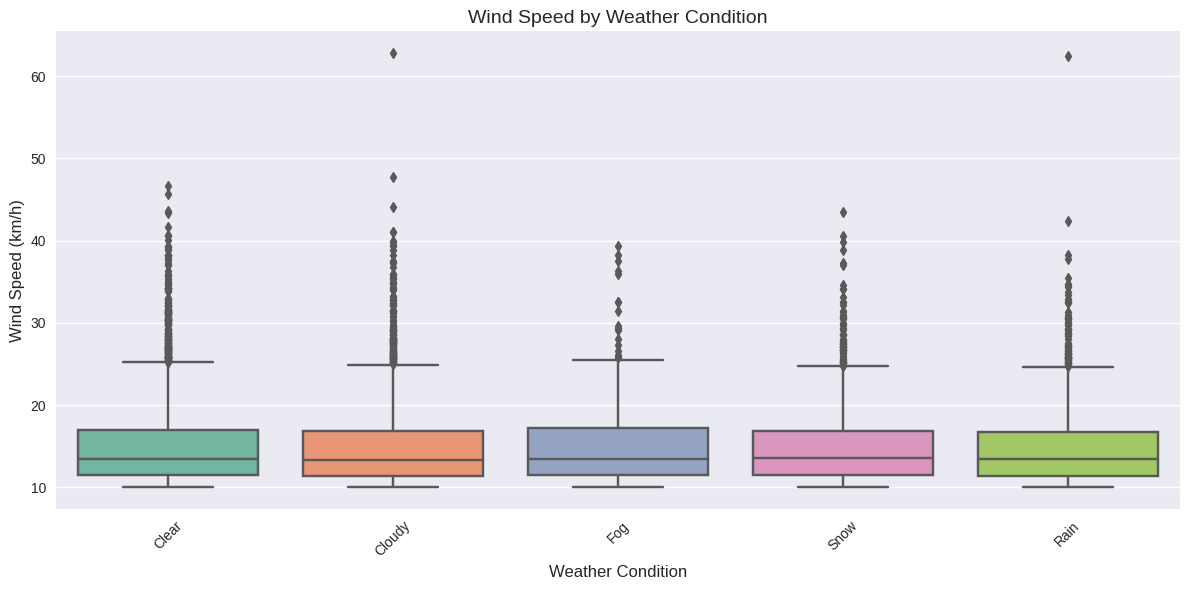

In [13]:
# 5. Wind speed analysis
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['wind_speed_kmh'], kde=True, bins=30)
plt.title('Wind Speed Distribution')
plt.xlabel('Wind Speed (km/h)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='season', y='wind_speed_kmh')
plt.title('Wind Speed by Season')
plt.xlabel('Season')
plt.ylabel('Wind Speed (km/h)')

plt.tight_layout()
plt.show()

# Wind speed vs. weather condition
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='weather_condition', y='wind_speed_kmh')
plt.title('Wind Speed by Weather Condition')
plt.xlabel('Weather Condition')
plt.ylabel('Wind Speed (km/h)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Feature Engineering

In this section, we'll create derived features to enhance our analysis and prepare the data for modeling.

In [14]:
# Create a copy of the dataframe for feature engineering
df_featured = df.copy()

# 1. Temperature changes (daily delta)
daily_temp = df.groupby(['location', 'date'])['temperature_celsius'].agg(['mean', 'min', 'max']).reset_index()
daily_temp['temp_range'] = daily_temp['max'] - daily_temp['min']

# Merge back to original dataframe
df_featured = pd.merge(df_featured, 
                       daily_temp[['location', 'date', 'temp_range']], 
                       on=['location', 'date'], 
                       how='left')

# 2. Pressure tendency (rising/falling)
# First, sort by location and datetime
df_featured = df_featured.sort_values(['location', 'datetime'])

# Calculate pressure change from previous observation (by location)
df_featured['pressure_change'] = df_featured.groupby('location')['pressure_mb'].diff()

# Create categorical feature for pressure tendency
df_featured['pressure_tendency'] = pd.cut(
    df_featured['pressure_change'], 
    bins=[-float('inf'), -1, 1, float('inf')],
    labels=['Falling', 'Steady', 'Rising']
)

# 3. Extreme weather indicator
df_featured['extreme_temp'] = (
    (df_featured['temperature_celsius'] > df_featured.groupby('location')['temperature_celsius'].transform('mean') + 2 * df_featured.groupby('location')['temperature_celsius'].transform('std')) | 
    (df_featured['temperature_celsius'] < df_featured.groupby('location')['temperature_celsius'].transform('mean') - 2 * df_featured.groupby('location')['temperature_celsius'].transform('std'))
)

# 4. Dew Point (estimate)
# Using Magnus formula for approximation
df_featured['dew_point'] = df_featured['temperature_celsius'] - ((100 - df_featured['humidity_percent']) / 5)

# 5. Heat Index (simplified version)
# Only calculated for temperatures above 20°C
mask = df_featured['temperature_celsius'] > 20
df_featured.loc[mask, 'heat_index'] = (
    df_featured.loc[mask, 'temperature_celsius'] + 
    0.05 * df_featured.loc[mask, 'humidity_percent'] *
    (df_featured.loc[mask, 'temperature_celsius'] - 20)
)
df_featured.loc[~mask, 'heat_index'] = df_featured.loc[~mask, 'temperature_celsius']

# 6. Season-normalized temperature (z-score within each season)
df_featured['season_norm_temp'] = df_featured.groupby(['location', 'season'])['temperature_celsius'].transform(
    lambda x: (x - x.mean()) / x.std() if len(x) > 1 and x.std() > 0 else 0
)

# 7. Weather severity index (simplified)
# Map weather conditions to severity scores
severity_map = {
    'Clear': 1,
    'Cloudy': 2,
    'Fog': 3,
    'Rain': 4,
    'Snow': 5
}

# Apply mapping if weather_condition column contains these values
if set(severity_map.keys()).intersection(set(df_featured['weather_condition'].unique())):
    df_featured['weather_severity'] = df_featured['weather_condition'].map(severity_map).fillna(1)
else:
    # Create a simple severity based on wind speed and temperature extremes as fallback
    df_featured['weather_severity'] = 1
    df_featured.loc[df_featured['wind_speed_kmh'] > 20, 'weather_severity'] += 1
    df_featured.loc[df_featured['wind_speed_kmh'] > 40, 'weather_severity'] += 1
    df_featured.loc[df_featured['extreme_temp'], 'weather_severity'] += 1

# Display the newly engineered features
print("Feature engineering complete. New columns added:")
new_columns = ['temp_range', 'pressure_change', 'pressure_tendency', 'extreme_temp',
              'dew_point', 'heat_index', 'season_norm_temp', 'weather_severity']
df_featured[new_columns].describe().round(2)

Feature engineering complete. New columns added:


temp_range  pressure_change  dew_point  heat_index  season_norm_temp  \
count     10970.0         10965.00   10970.00    10970.00          10970.00   
mean          0.0             0.00       4.44       15.85              0.00   
std           0.0             7.11       9.31       14.95              1.00   
min           0.0           -25.80     -20.40      -11.10             -3.34   
25%           0.0            -4.80      -3.00        5.30             -0.72   
50%           0.0             0.00       3.06       10.50             -0.00   
75%           0.0             4.80      12.36       22.52              0.72   
max           0.0            25.90      31.58       98.82              3.91   

       weather_severity  
count          10970.00  
mean               2.29  
std                1.40  
min                1.00  
25%                1.00  
50%                2.00  
75%                4.00  
max                5.00

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


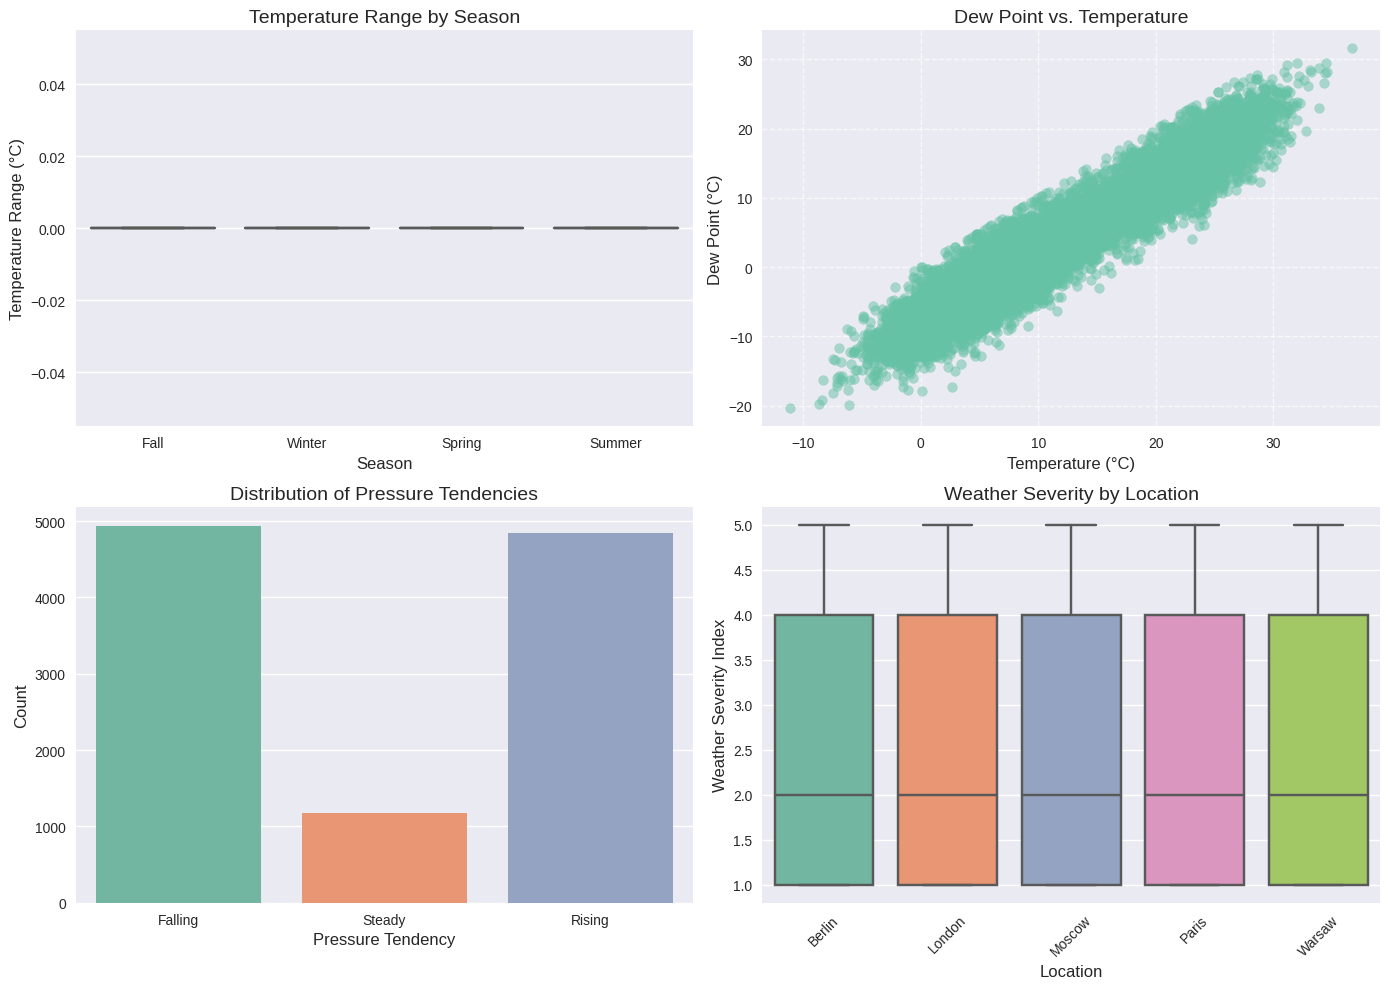

In [15]:
# Visualize some of the new features
plt.figure(figsize=(14, 10))

# Plot 1: Temperature Range by Season
plt.subplot(2, 2, 1)
sns.boxplot(data=df_featured, x='season', y='temp_range')
plt.title('Temperature Range by Season')
plt.xlabel('Season')
plt.ylabel('Temperature Range (°C)')

# Plot 2: Dew Point vs. Temperature
plt.subplot(2, 2, 2)
plt.scatter(df_featured['temperature_celsius'], df_featured['dew_point'], alpha=0.5)
plt.title('Dew Point vs. Temperature')
plt.xlabel('Temperature (°C)')
plt.ylabel('Dew Point (°C)')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 3: Pressure Tendency Distribution
plt.subplot(2, 2, 3)
pressure_tendency_counts = df_featured['pressure_tendency'].value_counts()
sns.barplot(x=pressure_tendency_counts.index, y=pressure_tendency_counts.values)
plt.title('Distribution of Pressure Tendencies')
plt.xlabel('Pressure Tendency')
plt.ylabel('Count')

# Plot 4: Weather Severity by Location
plt.subplot(2, 2, 4)
sns.boxplot(data=df_featured, x='location', y='weather_severity')
plt.title('Weather Severity by Location')
plt.xlabel('Location')
plt.ylabel('Weather Severity Index')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## 6. Time Series Analysis

Let's analyze weather patterns over time and decompose time series to identify trends and seasonality in the data.

Focusing on location: London


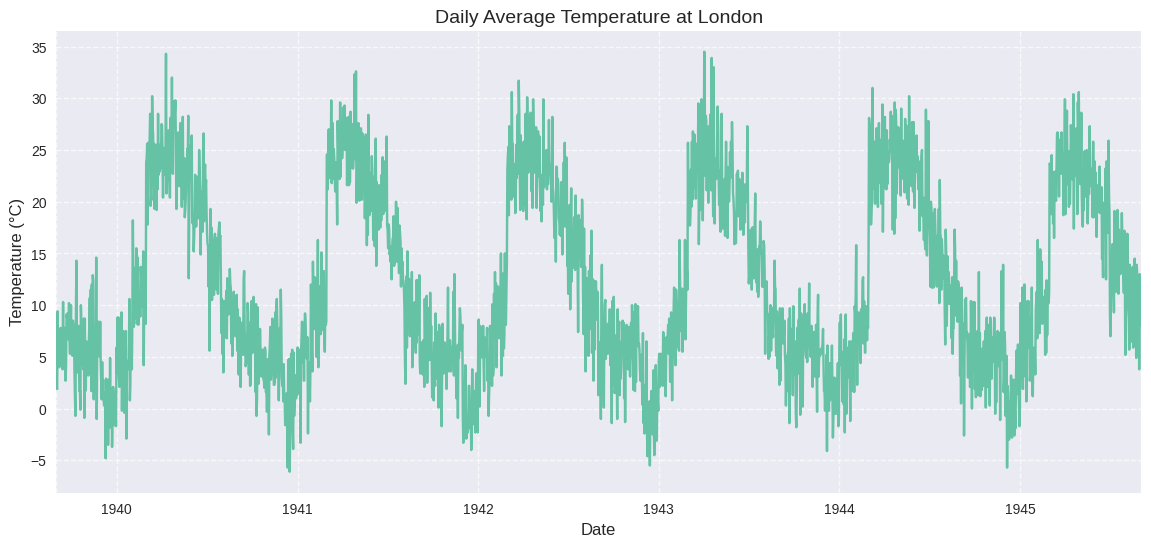

ADF Statistic: -2.9518408349439533
p-value: 0.03964323089079699
Critical Values:
   1%: -3.4333477117905487
   5%: -2.8628642889373044
   10%: -2.5674749845110627
The time series is stationary (reject H0)


In [16]:
# Select a single location for time series analysis
# For demonstration, we'll use the first location in our dataset
location_focus = df['location'].unique()[0]
print(f"Focusing on location: {location_focus}")

# Create a time series dataset for selected location
ts_data = df[df['location'] == location_focus].set_index('datetime').sort_index()

# Resample to daily average temperature
daily_avg_temp = ts_data['temperature_celsius'].resample('D').mean()

# Handling missing values in the resampled data
daily_avg_temp = daily_avg_temp.interpolate()

# Plot the time series
plt.figure(figsize=(14, 6))
daily_avg_temp.plot()
plt.title(f'Daily Average Temperature at {location_focus}')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Check stationarity with ADF test
result = adfuller(daily_avg_temp.dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

# Interpret results
if result[1] <= 0.05:
    print("The time series is stationary (reject H0)")
else:
    print("The time series is non-stationary (fail to reject H0)")

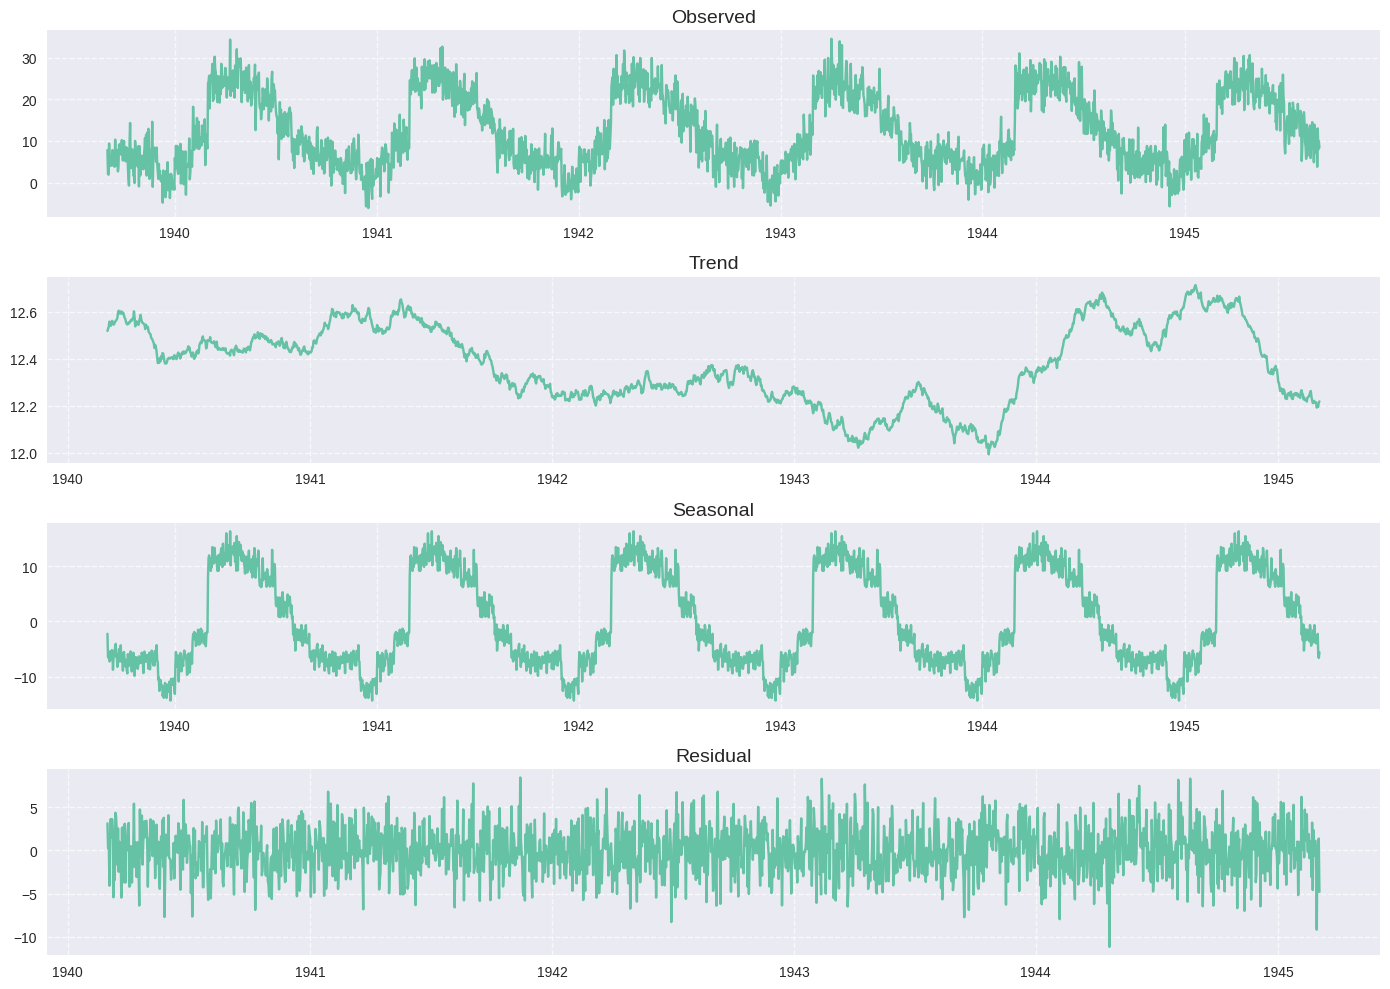

In [17]:
# Time Series Decomposition
# For decomposition, we need a time series without missing values
decomposition = seasonal_decompose(daily_avg_temp.dropna(), model='additive', period=365)

# Plot decomposition
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Observed')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Trend')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Seasonal')
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Residual')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

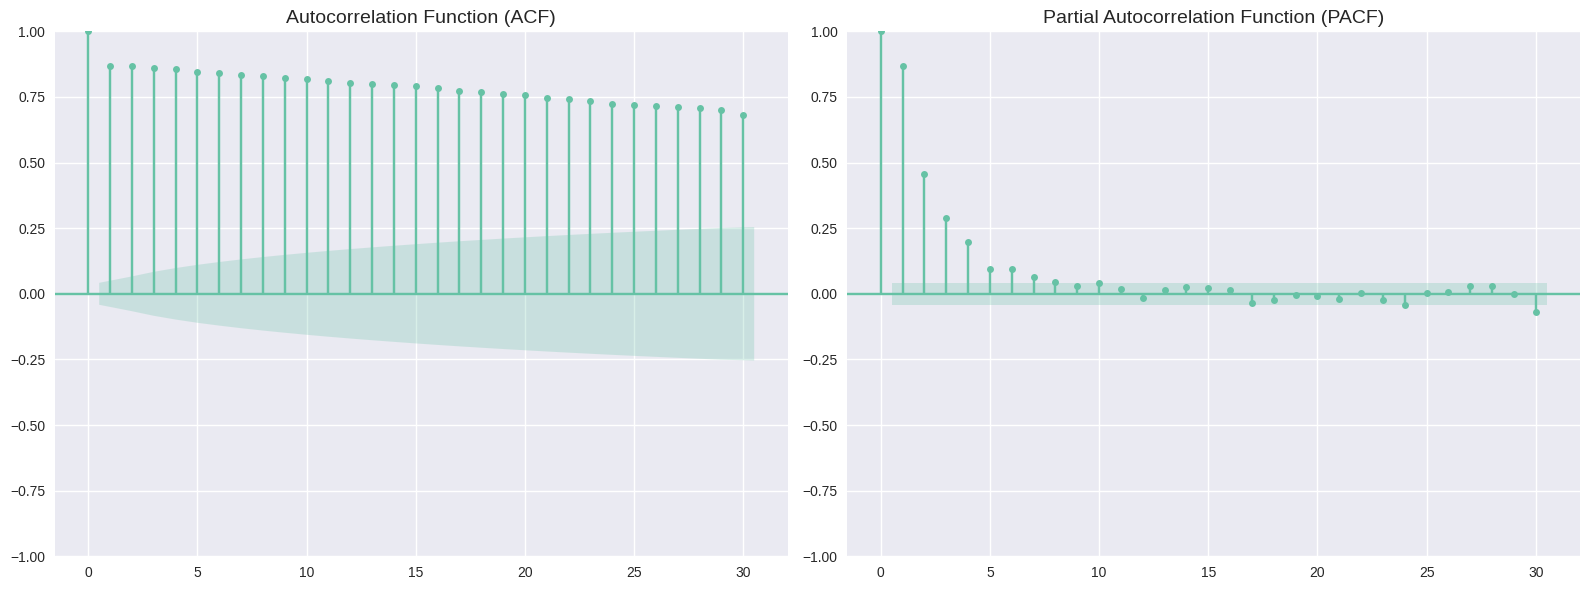

In [18]:
# ACF and PACF plots for understanding autocorrelation patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(daily_avg_temp.dropna(), ax=axes[0], lags=30)
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(daily_avg_temp.dropna(), ax=axes[1], lags=30)
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

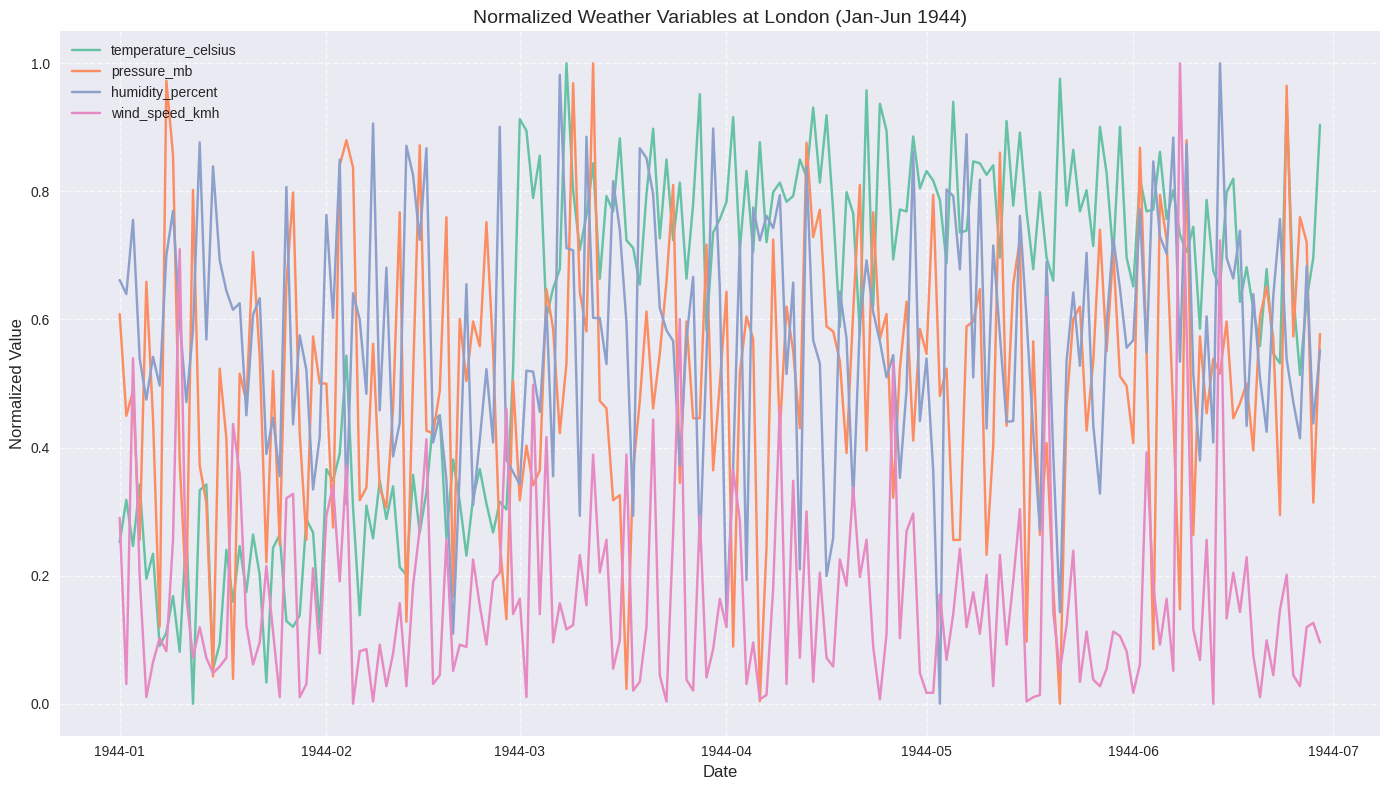

In [19]:
# Plot multiple weather variables together for comparative time series analysis
# Select a subset of dates for better visualization
date_start = pd.to_datetime('1944-01-01')
date_end = pd.to_datetime('1944-06-30')

# Filter the data for the selected date range
ts_subset = ts_data.loc[date_start:date_end]

# Resampling to daily averages for multiple variables
daily_avg = ts_subset.resample('D').agg({
    'temperature_celsius': 'mean',
    'pressure_mb': 'mean',
    'humidity_percent': 'mean',
    'wind_speed_kmh': 'mean'
}).dropna()

# Normalize the data for comparison on same scale
scaler = MinMaxScaler()
normalized_data = pd.DataFrame(
    scaler.fit_transform(daily_avg),
    columns=daily_avg.columns,
    index=daily_avg.index
)

# Plot the normalized time series
plt.figure(figsize=(14, 8))
for column in normalized_data.columns:
    plt.plot(normalized_data.index, normalized_data[column], label=column)

plt.title(f'Normalized Weather Variables at {location_focus} (Jan-Jun 1944)')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis

Let's investigate relationships between different weather variables and identify significant dependencies in weather patterns.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


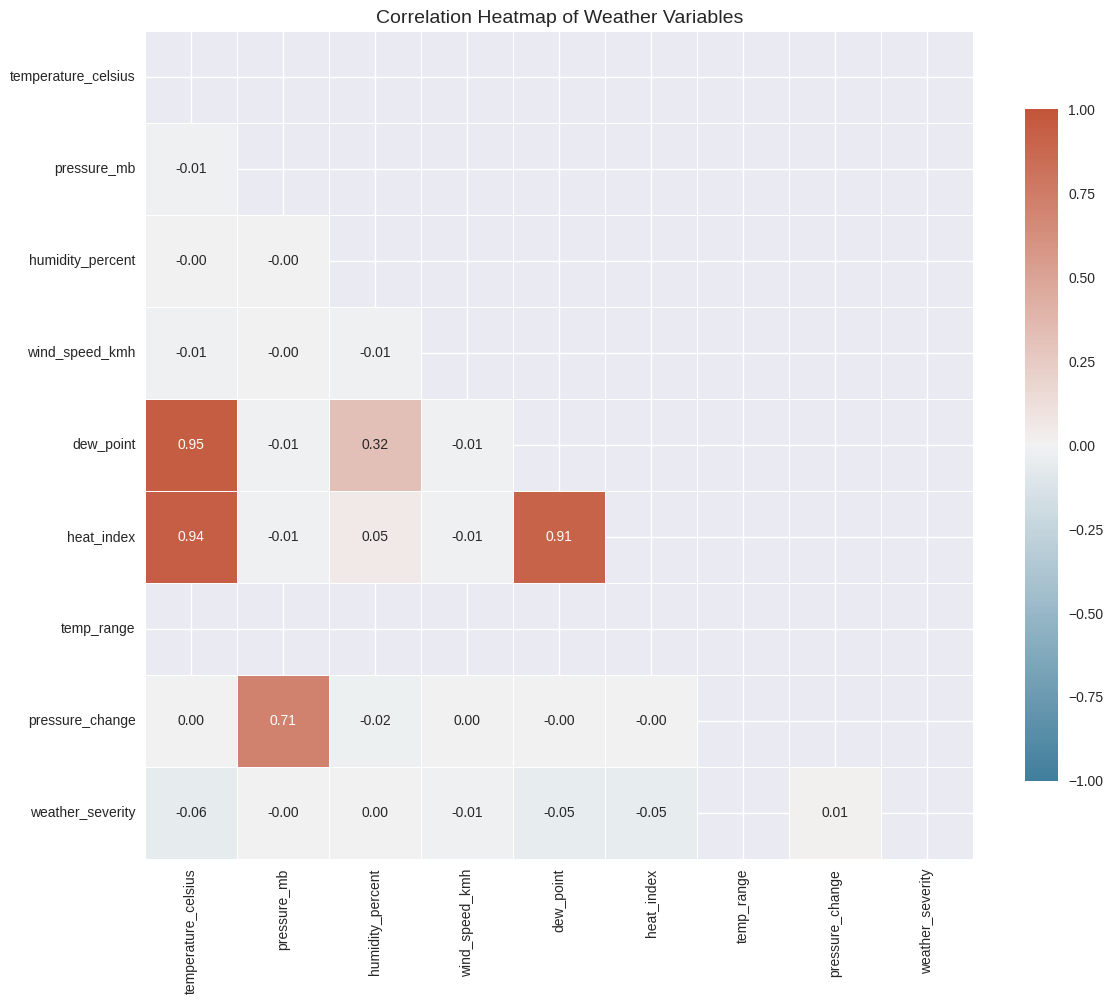

In [20]:
# Select relevant numerical columns for correlation analysis
corr_columns = ['temperature_celsius', 'pressure_mb', 'humidity_percent', 'wind_speed_kmh', 
                'dew_point', 'heat_index', 'temp_range', 'pressure_change', 'weather_severity']
corr_df = df_featured[corr_columns].copy()

# Calculate correlation matrix
correlation_matrix = corr_df.corr().round(2)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .8})

plt.title('Correlation Heatmap of Weather Variables')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


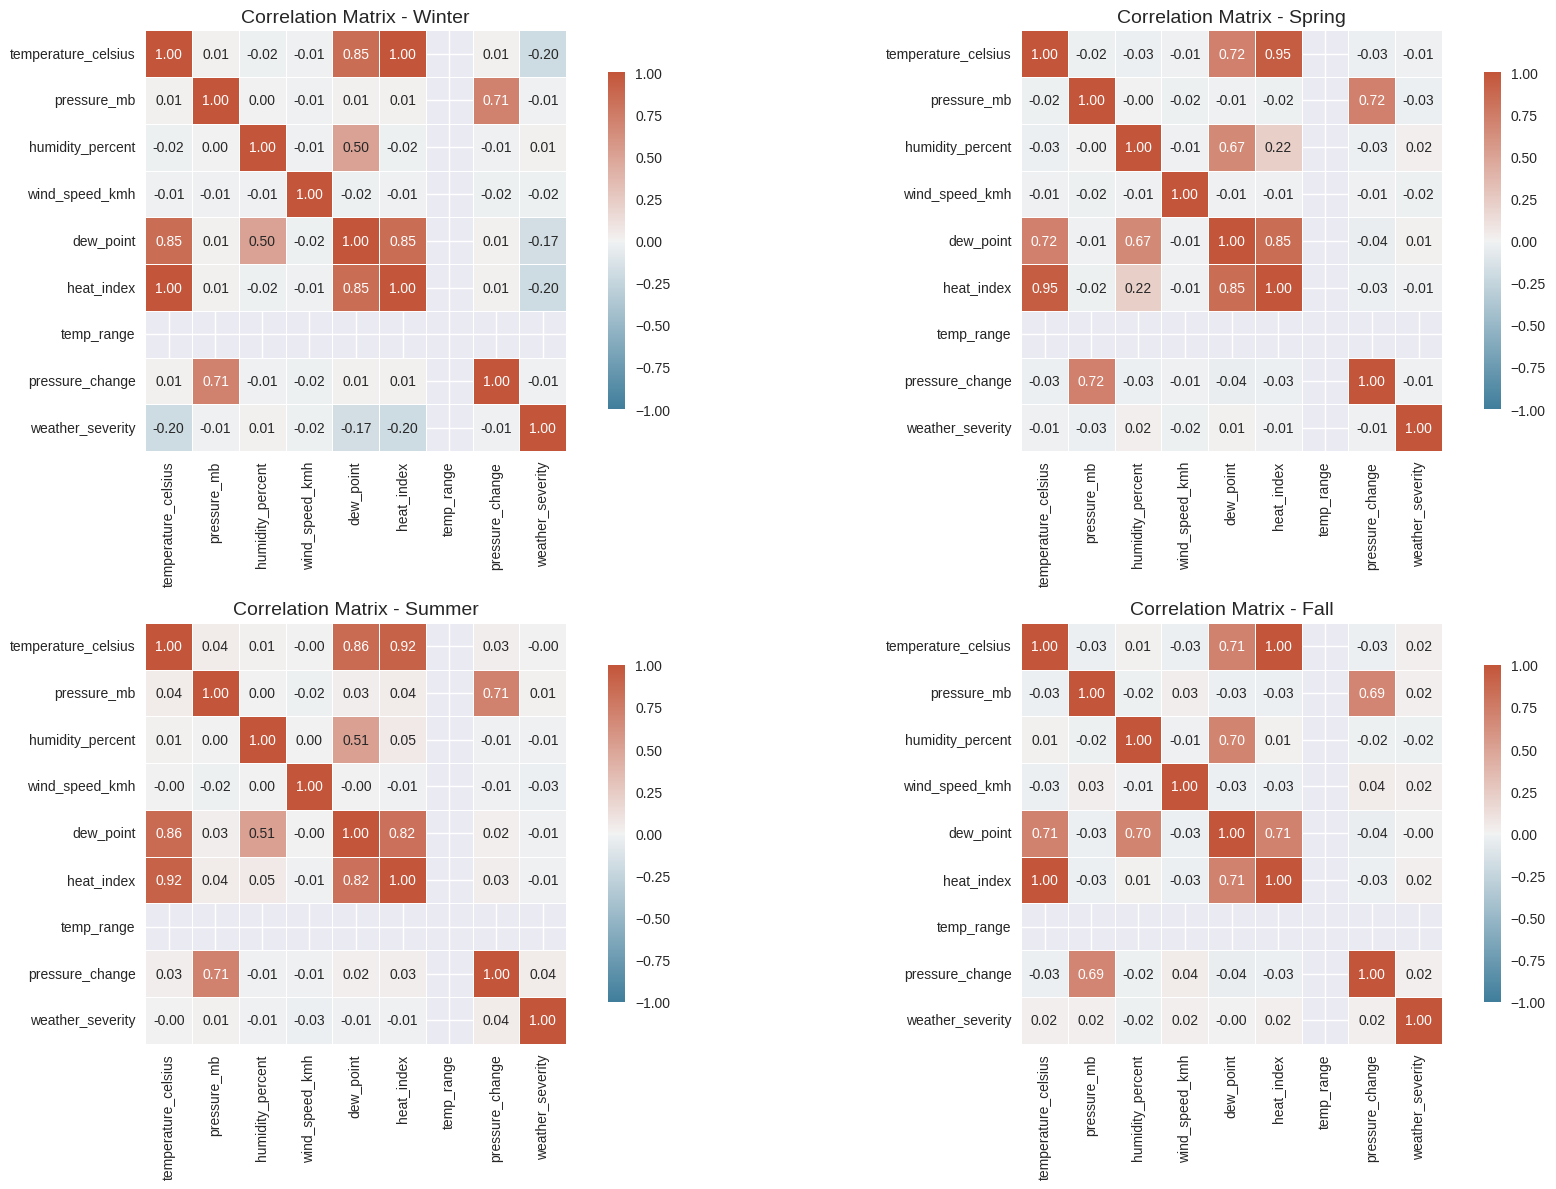

In [21]:
# Investigate correlation patterns by season
plt.figure(figsize=(18, 12))

for i, season in enumerate(['Winter', 'Spring', 'Summer', 'Fall'], 1):
    # Filter data by season
    season_data = df_featured[df_featured['season'] == season][corr_columns].copy()
    
    # Calculate correlation matrix for this season
    season_corr = season_data.corr().round(2)
    
    # Plot
    plt.subplot(2, 2, i)
    sns.heatmap(season_corr, cmap=cmap, vmax=1, vmin=-1, center=0,
                annot=True, fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'Correlation Matrix - {season}')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

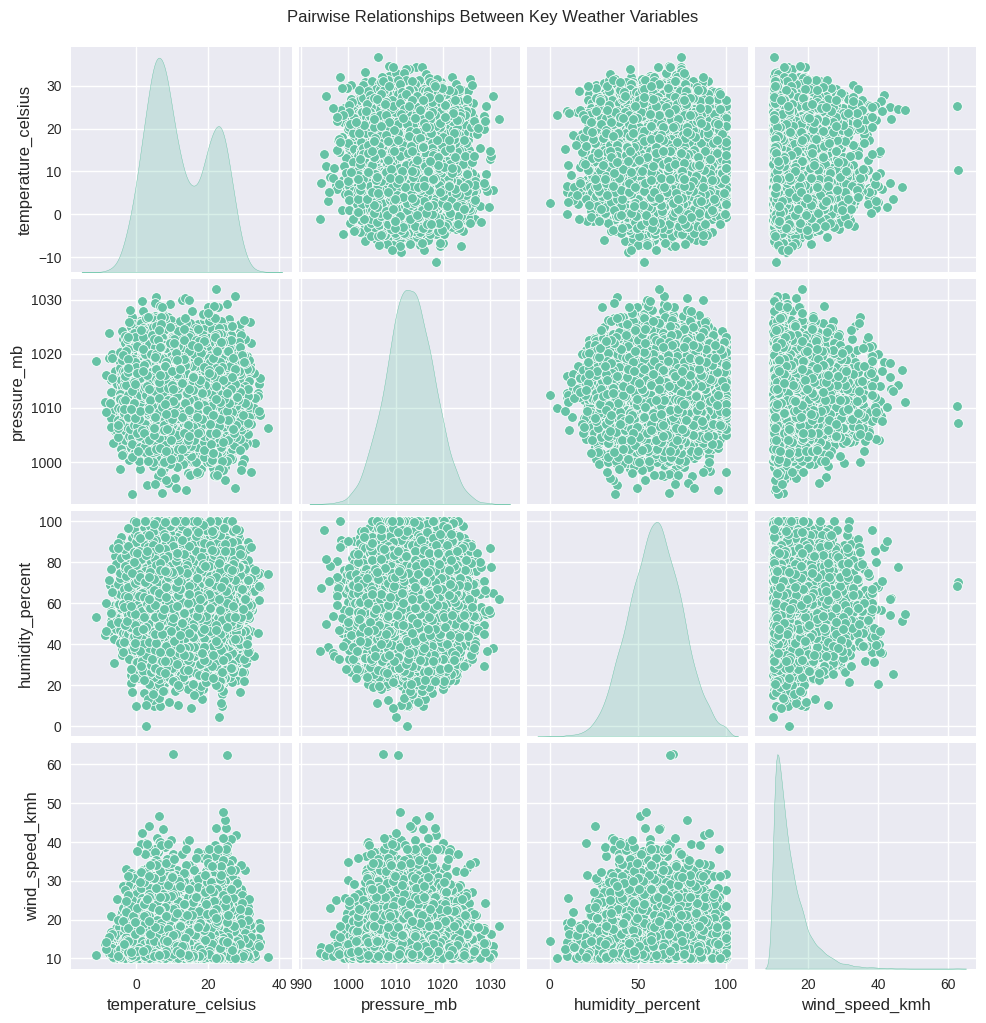

In [22]:
# Scatter plot matrix for key variables
subset_vars = ['temperature_celsius', 'pressure_mb', 'humidity_percent', 'wind_speed_kmh']
sns.pairplot(df_featured[subset_vars], diag_kind='kde', height=2.5)
plt.suptitle('Pairwise Relationships Between Key Weather Variables', y=1.02)
plt.show()

## 8. Geospatial Visualization

Now let's visualize weather data geographically to identify spatial patterns and regional variations.

In [23]:
# Create a base map centered on Europe
map_center = [50.0, 10.0]  # Approximate center of Europe
europe_map = folium.Map(location=map_center, zoom_start=4, tiles='CartoDB positron')

# Function to calculate average values for a specific date
def get_data_for_date(selected_date):
    date_data = df_featured[df_featured['date'] == selected_date].copy()
    
    if len(date_data) == 0:
        print(f"No data available for {selected_date}")
        return None
    
    # Group by location and calculate averages
    location_avg = date_data.groupby(['location', 'latitude', 'longitude']).agg({
        'temperature_celsius': 'mean',
        'pressure_mb': 'mean',
        'humidity_percent': 'mean',
        'wind_speed_kmh': 'mean',
        'weather_condition': lambda x: x.mode()[0] if not x.mode().empty else 'Unknown'
    }).reset_index()
    
    return location_avg

# Select a specific date for visualization
selected_date = df_featured['date'].iloc[len(df_featured) // 2]  # Choose a middle date
print(f"Visualizing weather for date: {selected_date}")

date_data = get_data_for_date(selected_date)

if date_data is not None:
    # Create a marker cluster group
    marker_cluster = MarkerCluster().add_to(europe_map)
    
    # Add markers for each location with weather information
    for idx, row in date_data.iterrows():
        # Create marker popup with weather information
        popup_html = f"""
        <b>{row['location']}</b><br>
        Temperature: {row['temperature_celsius']:.1f}°C<br>
        Pressure: {row['pressure_mb']:.1f} mb<br>
        Humidity: {row['humidity_percent']:.1f}%<br>
        Wind Speed: {row['wind_speed_kmh']:.1f} km/h<br>
        Condition: {row['weather_condition']}
        """
        
        # Color based on temperature
        if row['temperature_celsius'] < 0:
            color = 'blue'
        elif row['temperature_celsius'] < 10:
            color = 'lightblue'
        elif row['temperature_celsius'] < 20:
            color = 'green'
        elif row['temperature_celsius'] < 30:
            color = 'orange'
        else:
            color = 'red'
            
        # Create circle marker
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=10,
            popup=folium.Popup(popup_html, max_width=300),
            fill=True,
            color=color,
            fill_opacity=0.7,
            tooltip=f"{row['location']}: {row['temperature_celsius']:.1f}°C"
        ).add_to(marker_cluster)
    
    # Add a title to the map
    title_html = f'''
        <h3 align="center" style="font-size:16px"><b>Weather Conditions on {selected_date}</b></h3>
    '''
    europe_map.get_root().html.add_child(folium.Element(title_html))
    
    # Display the map
    europe_map
else:
    print("No data available for visualization.")

Visualizing weather for date: 1942-09-02


In [24]:
# Create a temperature heatmap
# This demonstrates how temperature varies across different locations

# Get average temperatures for all locations
avg_temps = df_featured.groupby(['location', 'latitude', 'longitude'])['temperature_celsius'].mean().reset_index()

# Create a base map
temp_heatmap = folium.Map(location=map_center, zoom_start=4, tiles='CartoDB positron')

# Prepare data for heatmap
heat_data = [[row['latitude'], row['longitude'], row['temperature_celsius']] for idx, row in avg_temps.iterrows()]

# Add heatmap layer
HeatMap(heat_data, radius=15, max_zoom=13, blur=10, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 1: 'red'}).add_to(temp_heatmap)

# Add markers for reference
for idx, row in avg_temps.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        popup=f"{row['location']}: {row['temperature_celsius']:.1f}°C",
        color='white',
        fill=True,
        fill_color='black',
        fill_opacity=0.7
    ).add_to(temp_heatmap)

# Add title
title_html = '''
    <h3 align="center" style="font-size:16px"><b>Average Temperature Heatmap</b></h3>
'''
temp_heatmap.get_root().html.add_child(folium.Element(title_html))

# Display the heatmap
temp_heatmap

AttributeError: 'float' object has no attribute 'split'

## 9. Weather Pattern Classification

In this section, we'll implement clustering algorithms to identify distinct weather patterns in our dataset.

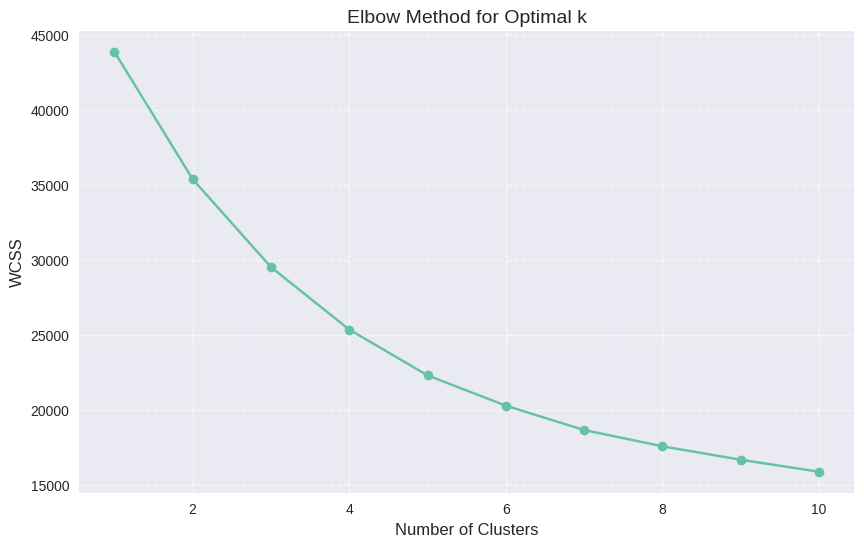

In [25]:
# Prepare data for clustering
# We'll use key weather variables and standardize them

# Select features for clustering
cluster_features = ['temperature_celsius', 'pressure_mb', 'humidity_percent', 'wind_speed_kmh']
cluster_data = df_featured[cluster_features].copy()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cluster_data)

# Determine optimal number of clusters using elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Cluster Centers:
   temperature_celsius  pressure_mb  humidity_percent  wind_speed_kmh
0                 8.02      1015.61             47.46           13.53
1                22.78      1012.67             61.62           13.72
2                11.69      1013.01             59.71           25.47
3                 6.27      1010.98             69.72           13.52


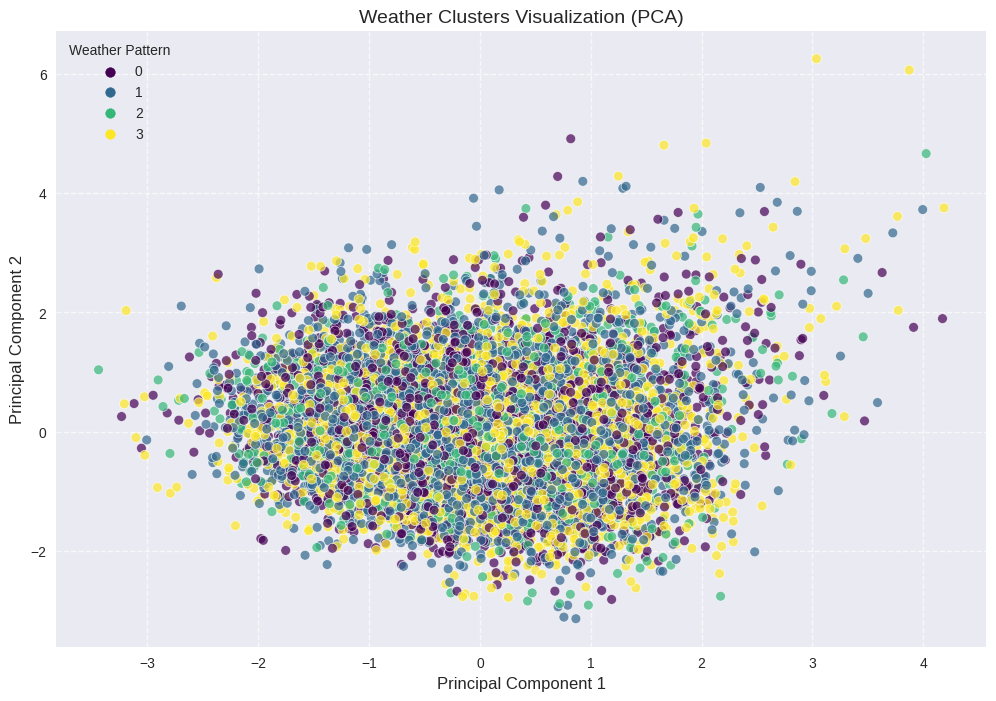

In [26]:
# Based on the elbow curve, select an appropriate number of clusters
n_clusters = 4  # This should be adjusted based on your actual elbow curve

# Apply K-means clustering
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
df_featured['weather_cluster'] = kmeans.fit_predict(scaled_data)

# Get cluster centers and transform back to original scale
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(kmeans.cluster_centers_),
    columns=cluster_features
)

# Display cluster centers
print("Cluster Centers:")
print(cluster_centers.round(2))

# Visualize the clusters in 2D using PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = df_featured['weather_cluster']

# Create a scatter plot colored by cluster
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=50, alpha=0.7)
plt.title('Weather Clusters Visualization (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weather Pattern')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

Cluster Characteristics:


temperature_celsius  pressure_mb  humidity_percent  \
weather_cluster                                                       
0                               7.99      1015.61             47.49   
1                              22.78      1012.67             61.60   
2                              11.70      1013.00             59.72   
3                               6.28      1010.97             69.75   

                 wind_speed_kmh  dew_point  heat_index  weather_severity  
weather_cluster                                                           
0                         13.53      -2.51        8.13              2.32  
1                         13.71      15.10       32.89              2.24  
2                         25.47       3.64       14.17              2.25  
3                         13.52       0.23        6.28              2.33


Weather Conditions by Cluster (%):


weather_condition  Clear  Cloudy  Fog  Rain  Snow
weather_cluster                                  
0                   38.2    30.5  4.7  14.6  12.0
1                   40.8    28.7  5.2  15.8   9.5
2                   41.3    28.8  5.2  13.1  11.6
3                   38.4    29.6  5.0  14.4  12.6

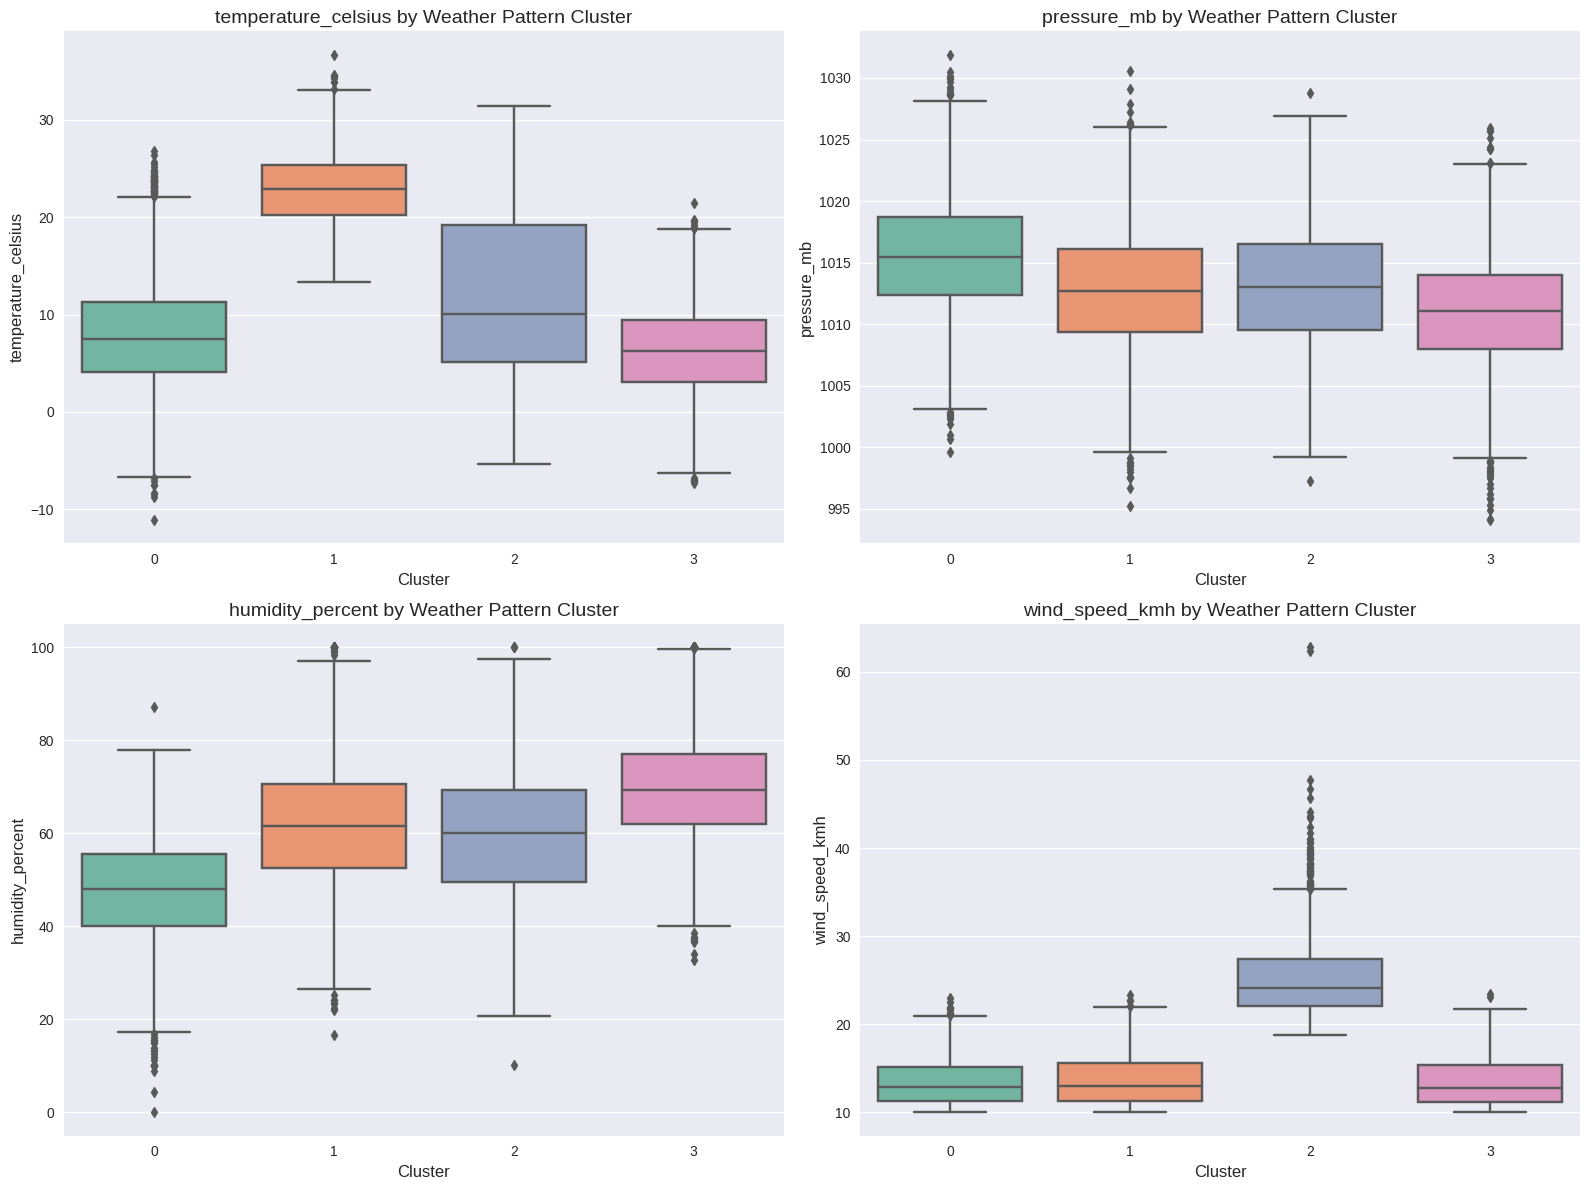

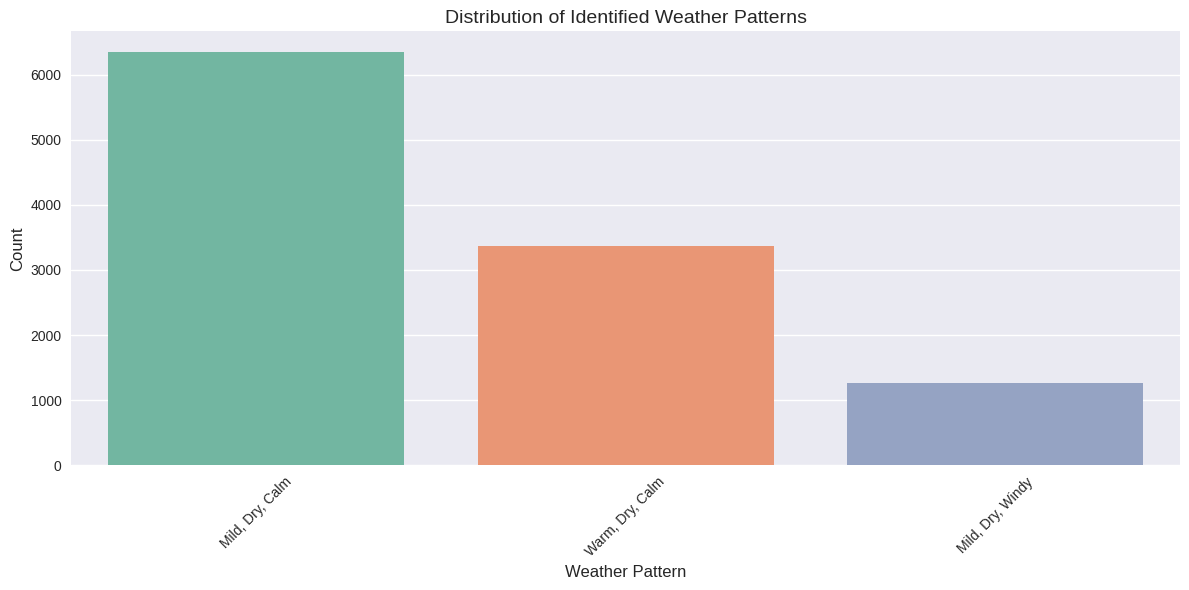

In [27]:
# Analyze the characteristics of each cluster
cluster_analysis = df_featured.groupby('weather_cluster').agg({
    'temperature_celsius': 'mean',
    'pressure_mb': 'mean',
    'humidity_percent': 'mean',
    'wind_speed_kmh': 'mean',
    'dew_point': 'mean',
    'heat_index': 'mean',
    'weather_severity': 'mean'
}).round(2)

print("Cluster Characteristics:")
display(cluster_analysis)

# Distribution of weather conditions within each cluster
weather_by_cluster = pd.crosstab(
    df_featured['weather_cluster'], 
    df_featured['weather_condition'], 
    normalize='index'
) * 100

print("\nWeather Conditions by Cluster (%):")
display(weather_by_cluster.round(1))

# Visualize distributions for each feature by cluster
plt.figure(figsize=(16, 12))

for i, feature in enumerate(cluster_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='weather_cluster', y=feature, data=df_featured)
    plt.title(f'{feature} by Weather Pattern Cluster')
    plt.xlabel('Cluster')
    
plt.tight_layout()
plt.show()

# Create descriptive labels for each cluster
cluster_descriptions = {
    0: "Undefined",  # This will be updated based on analysis
    1: "Undefined",
    2: "Undefined",
    3: "Undefined"
}

# Example: Update with meaningful labels based on the cluster analysis results
# This should be updated based on your actual cluster characteristics
for cluster in range(n_clusters):
    if cluster_analysis.loc[cluster, 'temperature_celsius'] > 20:
        prefix = "Warm"
    elif cluster_analysis.loc[cluster, 'temperature_celsius'] < 5:
        prefix = "Cold"
    else:
        prefix = "Mild"
        
    if cluster_analysis.loc[cluster, 'humidity_percent'] > 70:
        humidity = "Humid"
    else:
        humidity = "Dry"
        
    if cluster_analysis.loc[cluster, 'wind_speed_kmh'] > 15:
        wind = "Windy"
    else:
        wind = "Calm"
        
    cluster_descriptions[cluster] = f"{prefix}, {humidity}, {wind}"

# Add descriptive labels to the dataframe
df_featured['weather_pattern'] = df_featured['weather_cluster'].map(cluster_descriptions)

# Show the distribution of weather patterns
pattern_distribution = df_featured['weather_pattern'].value_counts().reset_index()
pattern_distribution.columns = ['Weather Pattern', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(x='Weather Pattern', y='Count', data=pattern_distribution)
plt.title('Distribution of Identified Weather Patterns')
plt.xlabel('Weather Pattern')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 10. Predictive Modeling

In this section, we'll build and evaluate machine learning models to predict weather conditions based on historical patterns.

In [28]:
# Prepare data for predictive modeling
# We'll predict next-day temperature based on current weather conditions

# Create lagged features
model_data = df_featured.copy()

# Group by location and sort by datetime
model_data = model_data.sort_values(['location', 'datetime'])

# Create target variable: next-day temperature
model_data['next_day_temp'] = model_data.groupby('location')['temperature_celsius'].shift(-1)

# Create lags of 1, 2, and 3 days
for lag in range(1, 4):
    model_data[f'temp_lag_{lag}'] = model_data.groupby('location')['temperature_celsius'].shift(lag)
    model_data[f'pressure_lag_{lag}'] = model_data.groupby('location')['pressure_mb'].shift(lag)
    model_data[f'humidity_lag_{lag}'] = model_data.groupby('location')['humidity_percent'].shift(lag)
    model_data[f'wind_lag_{lag}'] = model_data.groupby('location')['wind_speed_kmh'].shift(lag)

# Drop rows with NaN values created by the shifts
model_data = model_data.dropna()

# Select features for the model
model_features = [
    'temperature_celsius', 'pressure_mb', 'humidity_percent', 'wind_speed_kmh',
    'temp_lag_1', 'temp_lag_2', 'temp_lag_3',
    'pressure_lag_1', 'pressure_lag_2', 'pressure_lag_3',
    'humidity_lag_1', 'humidity_lag_2', 'humidity_lag_3',
    'wind_lag_1', 'wind_lag_2', 'wind_lag_3',
    'month', 'season_norm_temp', 'temp_range'
]

# Prepare X and y
X = model_data[model_features]
y = model_data['next_day_temp']

# Add categorical features using one-hot encoding
X_encoded = pd.get_dummies(X, columns=['month'], drop_first=True)

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (8760, 29)
Testing data shape: (2190, 29)


Random Forest Model Evaluation:
Mean Squared Error (MSE): 11.0564
Root Mean Squared Error (RMSE): 3.3251
Mean Absolute Error (MAE): 2.6198
R² Score: 0.8582


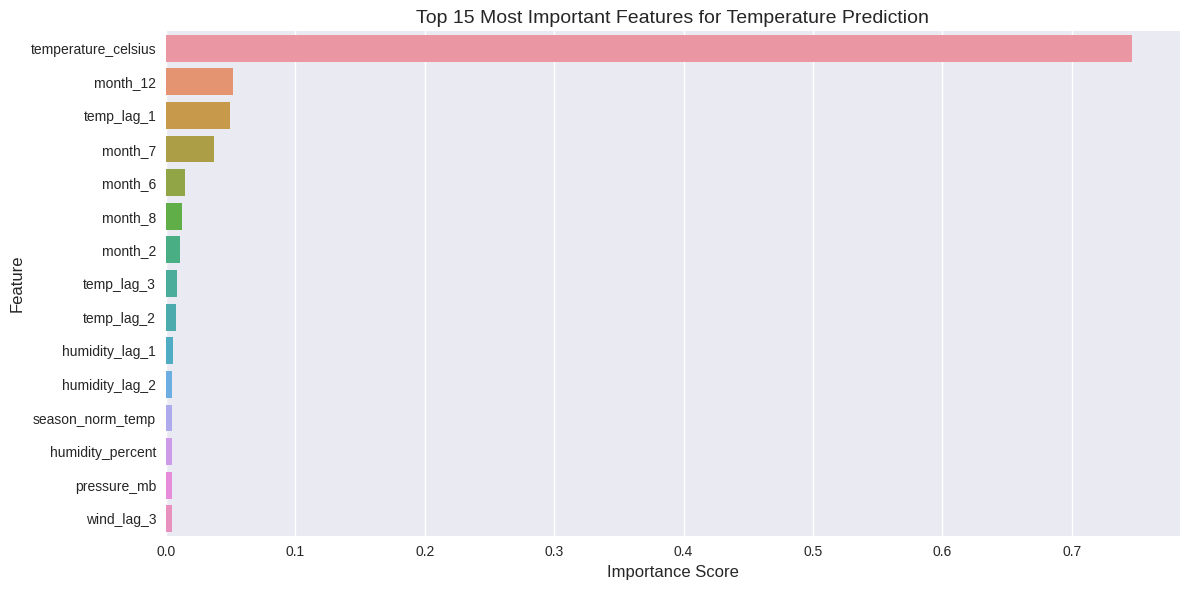

In [29]:
# Train a Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Display results
print("Random Forest Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R² Score: {r2_rf:.4f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
})

feature_importance = feature_importance.sort_values('Importance', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Top 15 Most Important Features for Temperature Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Gradient Boosting Model Evaluation:
Mean Squared Error (MSE): 11.1260
Root Mean Squared Error (RMSE): 3.3356
Mean Absolute Error (MAE): 2.6192
R² Score: 0.8573


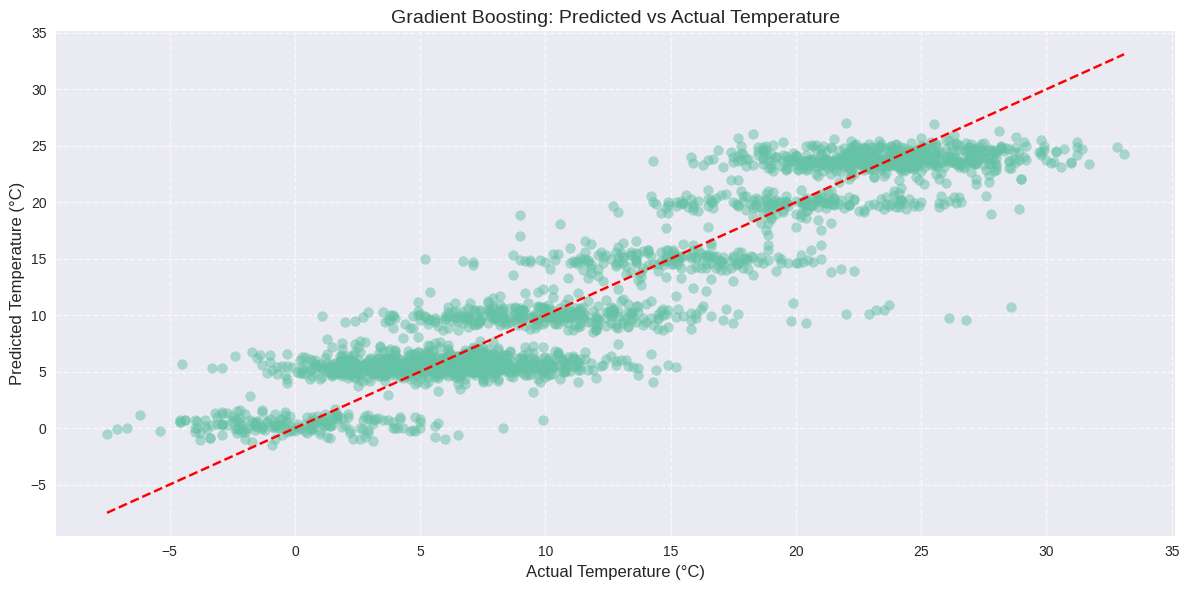

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


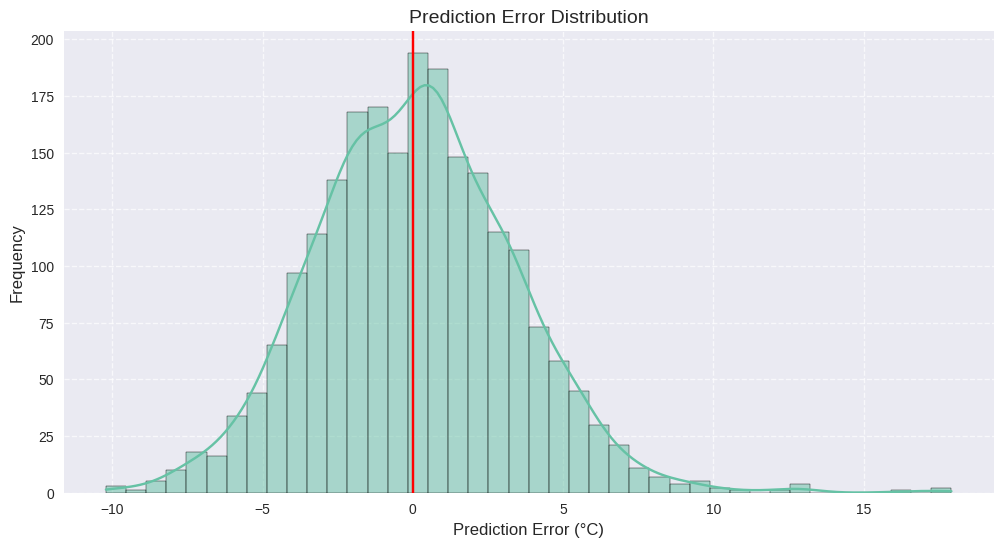

Model Comparison:


Model      RMSE       MAE        R²
0      Random Forest  3.325121  2.619759  0.858155
1  Gradient Boosting  3.335567  2.619167  0.857262

In [30]:
# Try a Gradient Boosting Regressor for comparison
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions
y_pred_gb = gb_model.predict(X_test)

# Calculate evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Display results
print("Gradient Boosting Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse_gb:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb:.4f}")
print(f"Mean Absolute Error (MAE): {mae_gb:.4f}")
print(f"R² Score: {r2_gb:.4f}")

# Visualize predictions vs actual values
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Gradient Boosting: Predicted vs Actual Temperature')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Calculate prediction errors
errors = y_test - y_pred_gb

# Plot error distribution
plt.figure(figsize=(12, 6))
sns.histplot(errors, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (°C)')
plt.ylabel('Frequency')
plt.axvline(x=0, color='r', linestyle='-')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Compare models
models_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'RMSE': [rmse_rf, rmse_gb],
    'MAE': [mae_rf, mae_gb],
    'R²': [r2_rf, r2_gb]
})

print("Model Comparison:")
display(models_comparison)

## 11. User interface

In [32]:
# Interactive UI for model testing and prediction
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import calendar


# Create widget components
location_dropdown = widgets.Dropdown(
    options=df['location'].unique(),
    value=df['location'].unique()[0],
    description='Location:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

input_method = widgets.RadioButtons(
    options=['Use random data', 'Enter manual data'],
    description='Input method:',
    style={'description_width': 'initial'}
)

# Create input widgets for manual data entry
temp_input = widgets.FloatSlider(
    value=15.0,
    min=-30.0,
    max=40.0,
    step=0.5,
    description='Temperature (°C):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

pressure_input = widgets.FloatSlider(
    value=1013.0,
    min=980.0,
    max=1040.0,
    step=0.5,
    description='Pressure (mb):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

humidity_input = widgets.FloatSlider(
    value=65.0,
    min=0.0,
    max=100.0,
    step=1.0,
    description='Humidity (%):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

wind_input = widgets.FloatSlider(
    value=10.0,
    min=0.0,
    max=50.0,
    step=0.5,
    description='Wind Speed (km/h):',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)

month_input = widgets.Dropdown(
    options=[(calendar.month_name[i], i) for i in range(1, 13)],
    value=1,
    description='Month:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='300px')
)

predict_button = widgets.Button(
    description='Predict Next-Day Temperature',
    button_style='success',
    layout=widgets.Layout(width='250px')
)

output_area = widgets.Output()

# Function to handle prediction
def on_predict_button_clicked(b):
    with output_area:
        clear_output()
        
        print("Processing prediction...")
        
        try:
            # Check which input method was selected
            if input_method.value == 'Use random data':
                # Get random sample from existing data for the selected location
                location_data = df[df['location'] == location_dropdown.value]
                if len(location_data) > 0:
                    random_idx = np.random.choice(location_data.index)
                    random_sample = location_data.loc[random_idx]
                    
                    # Display the selected random data
                    print(f"\n🔍 Using random data from {location_dropdown.value}:")
                    print(f"  • Date: {random_sample['date']}")
                    print(f"  • Temperature: {random_sample['temperature_celsius']:.1f}°C")
                    print(f"  • Pressure: {random_sample['pressure_mb']:.1f} mb")
                    print(f"  • Humidity: {random_sample['humidity_percent']:.1f}%")
                    print(f"  • Wind Speed: {random_sample['wind_speed_kmh']:.1f} km/h")
                    
                    # Create feature vector for prediction
                    # We'll need to handle all the features the model expects
                    # For demonstration, we're filling in with sample data and averages
                    
                    X_pred = pd.DataFrame({
                        'temperature_celsius': [random_sample['temperature_celsius']],
                        'pressure_mb': [random_sample['pressure_mb']],
                        'humidity_percent': [random_sample['humidity_percent']],
                        'wind_speed_kmh': [random_sample['wind_speed_kmh']],
                        'temp_lag_1': [random_sample['temperature_celsius']],
                        'temp_lag_2': [location_data['temperature_celsius'].mean()],
                        'temp_lag_3': [location_data['temperature_celsius'].mean()],
                        'pressure_lag_1': [random_sample['pressure_mb']],
                        'pressure_lag_2': [location_data['pressure_mb'].mean()],
                        'pressure_lag_3': [location_data['pressure_mb'].mean()],
                        'humidity_lag_1': [random_sample['humidity_percent']],
                        'humidity_lag_2': [location_data['humidity_percent'].mean()],
                        'humidity_lag_3': [location_data['humidity_percent'].mean()],
                        'wind_lag_1': [random_sample['wind_speed_kmh']],
                        'wind_lag_2': [location_data['wind_speed_kmh'].mean()],
                        'wind_lag_3': [location_data['wind_speed_kmh'].mean()],
                        'month': [random_sample['month']],
                        'season_norm_temp': [0.0],  # Default value
                        'temp_range': [10.0]  # Default value
                    })
                else:
                    print(f"No data available for {location_dropdown.value}")
                    return
                
            else:  # Manual data entry
                # Create feature vector from manual inputs
                X_pred = pd.DataFrame({
                    'temperature_celsius': [temp_input.value],
                    'pressure_mb': [pressure_input.value],
                    'humidity_percent': [humidity_input.value],
                    'wind_speed_kmh': [wind_input.value],
                    'temp_lag_1': [temp_input.value],  # Using current temp as lag 1
                    'temp_lag_2': [temp_input.value],  # Using current temp as lag 2
                    'temp_lag_3': [temp_input.value],  # Using current temp as lag 3
                    'pressure_lag_1': [pressure_input.value],
                    'pressure_lag_2': [pressure_input.value],
                    'pressure_lag_3': [pressure_input.value],
                    'humidity_lag_1': [humidity_input.value],
                    'humidity_lag_2': [humidity_input.value],
                    'humidity_lag_3': [humidity_input.value],
                    'wind_lag_1': [wind_input.value],
                    'wind_lag_2': [wind_input.value],
                    'wind_lag_3': [wind_input.value],
                    'month': [month_input.value],
                    'season_norm_temp': [0.0],  # Default value
                    'temp_range': [10.0]  # Default value
                })
                
                print(f"\n🔍 Using manually entered data for {location_dropdown.value}:")
                print(f"  • Temperature: {temp_input.value:.1f}°C")
                print(f"  • Pressure: {pressure_input.value:.1f} mb")
                print(f"  • Humidity: {humidity_input.value:.1f}%")
                print(f"  • Wind Speed: {wind_input.value:.1f} km/h")
                print(f"  • Month: {month_input.label}")
            
            # One-hot encode the month variable to match the training data
            # Create month columns (matching the training data)
            for i in range(2, 13):  # Assuming month_1 is dropped as reference
                col_name = f'month_{i}'
                X_pred[col_name] = 1 if X_pred['month'].values[0] == i else 0
            
            # Drop the original 'month' column
            X_pred = X_pred.drop(columns=['month'])
            
            # Add any missing columns from training data (with zeros)
            for col in X_train.columns:
                if col not in X_pred.columns:
                    X_pred[col] = 0
            
            # Ensure columns are in the same order as training data
            X_pred = X_pred[X_train.columns]
            
            # Make predictions with both models
            rf_prediction = rf_model.predict(X_pred)[0]
            gb_prediction = gb_model.predict(X_pred)[0]
            
            # Display results
            print("\n📊 Prediction Results:")
            print(f"  • Random Forest Prediction: {rf_prediction:.2f}°C")
            print(f"  • Gradient Boosting Prediction: {gb_prediction:.2f}°C")
            print(f"  • Average Prediction: {(rf_prediction + gb_prediction) / 2:.2f}°C")
            
            # Add some interpretative text
            current_temp = X_pred['temperature_celsius'].values[0]
            temp_diff = (rf_prediction + gb_prediction) / 2 - current_temp
            
            print("\n🔮 Forecast Interpretation:")
            if abs(temp_diff) < 1:
                print("  • Temperature expected to remain relatively stable")
            elif temp_diff > 0:
                print(f"  • Temperature expected to increase by approximately {temp_diff:.1f}°C")
            else:
                print(f"  • Temperature expected to decrease by approximately {abs(temp_diff):.1f}°C")
                
        except Exception as e:
            print(f"❌ Error during prediction: {e}")
            print("Make sure the model has been trained properly.")

# Connect button click event to handler
predict_button.on_click(on_predict_button_clicked)

# Create the layout
manual_inputs = widgets.VBox([temp_input, pressure_input, humidity_input, wind_input, month_input])
manual_inputs_container = widgets.VBox([manual_inputs], layout=widgets.Layout(display='none'))

def toggle_input_display(change):
    if change['new'] == 'Enter manual data':
        manual_inputs_container.layout.display = 'block'
    else:
        manual_inputs_container.layout.display = 'none'

input_method.observe(toggle_input_display, names='value')

# Final UI layout
header = widgets.HTML("<h2>Weather Prediction Model Testing</h2>")
ui = widgets.VBox([
    header,
    widgets.HBox([location_dropdown]),
    widgets.HBox([input_method]),
    manual_inputs_container,
    widgets.HBox([predict_button]),
    widgets.HTML("<h3>Results:</h3>"),
    output_area
])

# Display the UI
display(ui)